In [1]:
%config Completer.use_jedi = False

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# load necessary libraries
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import ArrowStyle
import math
import numpy as np
import networkx as nx
import os
import pandas as pd
import pickle
import random
from scipy.optimize import nnls
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import scipy
import scipy.cluster.hierarchy as sch
from scipy.stats import mannwhitneyu, normaltest
from scipy.spatial.distance import jensenshannon
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import affinity_propagation
from sklearn.metrics import pairwise_distances
from joblib import Parallel, delayed
import statsmodels.api as sm
from statannotations.Annotator import Annotator
import umap
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from itertools import product
import string

/home/atheistpoet/anaconda3/envs/scvi_cell_cycle_env/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/atheistpoet/anaconda3/envs/scvi_cell_cycle_env/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/atheistpoet/anaconda3/envs/s

In [4]:
# load required custom functions from utils
from utils import create_abundance_header_new, compute_cons_abun_prod, \
    hierarchical_cluster_metabs, \
    get_metabs_clusters, avg_consumption_df, fit_ss_Ri, match_lhs_rhs_fit, \
    blindly_pred_abun_growth, fit_dynamic_Ri, compute_growth_ratio_iterate_blind_seq, \
    blindly_pred_abun_growth_seq, blindly_pred_abun_loggrowth, remove_passages, \
    fit_dynamic_Ri_with_sim_inoc, \
    fit_dynamic_Ri_with_sim_inoc_bal, compute_Ri_dynamic_goodness_of_fit, \
    plot_panel_pred_vs_obs_abundance_blind, compute_growth_ratio_iterate_blind, \
    blindly_pred_abun_growth_without_inoc, load_data_manuscript, metabs_to_remove_knockdown_species, \
    get_RMSE_Balone_func, get_B_alone_func, iterate_growth_ratio, geometric_avg, \
    get_RMSE_against_uniform_sd, random_competition_index, random_crossfeeding_index, \
    get_competition, \
    get_competition_weighted, get_competition_weighted_2, \
    get_crossfeeding, random_competition_subset, compute_species_metab_matrix_for_nnls

# Load all required data

    load_data_manuscript
    Load data for the figures in the manuscript.

    Parameters:
    - thresh_zero (float): Threshold value for replacing zeros in the strain abundance data. Default is 1e-8.
    - data_dir (str): Directory path to the data. If None, the default data directory is used.

    Returns:
    - df_speciesMetab (pandas.DataFrame): Species-metabolite consumption matrix, c_{\\alpha, i}.
    - df_speciesAbun (pandas.DataFrame): Species abundance matrix, N_{alpha}(end of cycle k).
    - df_speciesAbun_inoc (pandas.DataFrame): Species abundance matrix for the inoculum, N_{alpha}(inoculum).
    - df_speciesAbun_ratio (pandas.DataFrame): Species abundance ratio matrix, N_{alpha}(end of cycle k) / N_{alpha}(end of cycle k - 1).
    - df_speciesAbun_prev (pandas.DataFrame): Species abundance matrix for previous passages N_{alpha}(end of cycle k - 1).
    - df_speciesAbun_next (pandas.DataFrame): Species abundance matrix for next passages, N_{alpha}(end of cycle k).
    - metab_names (numpy.ndarray): Array of metabolite names.
    - species_names (numpy.ndarray): Array of species names.
    - df_speciesMetab_prod (pandas.DataFrame): Species-metabolite production matrix, p_{\\gamma, i}.

In [5]:
# df_speciesMetab, df_speciesAbun, \
#     df_speciesAbun_inoc, \
#     df_speciesAbun_ratio, \
#     df_speciesAbun_prev, \
#     df_speciesAbun_next, metab_names, \
#     species_names_tmp, df_speciesMetab_prod = \
#         load_data_manuscript(thresh_zero=1e-8)

# load manuscript data

In [20]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data_manuscript'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, \
                                         f'greedy_algorithm_results.pickle'))


with open(file_save, "rb") as file_:
     Ri_adjust_obj = pickle.load(file_)
solution_list = Ri_adjust_obj['solution_list']
error_traj_list = Ri_adjust_obj['error_traj_list']

In [23]:
# read all data required to reproduce the figures in the manuscript
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data_manuscript'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, \
                                         f'data_to_reproduce_manuscript_figures.pickle'))
with open(file_save, "rb") as file_:
        data_obj = pickle.load(file_)
df_speciesMetab = data_obj['df_speciesMetab']
df_speciesMetab_prod = data_obj['df_speciesMetab_prod']
df_speciesAbun = data_obj['df_speciesAbun']
df_speciesAbun_inoc = data_obj['df_speciesAbun_inoc']
df_speciesAbun_ratio = data_obj['df_speciesAbun_ratio']
df_speciesAbun_prev = data_obj['df_speciesAbun_prev']
df_speciesAbun_next = data_obj['df_speciesAbun_next']
metab_names = data_obj['metab_names']
species_names = data_obj['species_names']
species_names_abbr = data_obj['species_names_abbr']
Ri_dynamic_obj = data_obj['Ri_dynamic_obj']
df_metabs_clusters = data_obj['df_metabs_clusters']
df_speciesMetab_cluster = data_obj['df_speciesMetab_cluster']
df_speciesMetab_prod_cluster = data_obj['df_speciesMetab_prod_cluster']

In [102]:
strains_remove = \
    np.array(["Clostridium scindens ATCC 35704", "Clostridium hylemonae DSMZ 15053"], \
             dtype=object)


In [103]:
df_speciesAbun.index.values

array(['Acidaminococcus fermentans DSMZ 20731',
       'Acidaminococcus intestini D21 BEI HM-81',
       'Anaerostipes caccae DSMZ 14662',
       'Anaerotruncus colihominis DSMZ 17241',
       'Bacteroides caccae ATCC 43185',
       'Bacteroides cellulosilyticus DSMZ 14838',
       'Bacteroides coprophilus DSMZ 18228',
       'Bacteroides dorei 5_1_36/D4 BEI HM-29',
       'Bacteroides dorei DSMZ 17855', 'Bacteroides eggerthii ATCC 27754',
       'Bacteroides finegoldii DSMZ 17565',
       'Bacteroides fragilis 3_1_12 BEI HM-20',
       'Bacteroides intestinalis DSMZ 17393',
       'Bacteroides ovatus ATCC 8483', 'Bacteroides plebeius DSMZ 17135',
       'Bacteroides sp. 1_1_6 BEI HM-23',
       'Bacteroides sp. 2_1_16 BEI HM-58',
       'Bacteroides sp. 2_1_22 BEI HM-18',
       'Bacteroides sp. 3_1_19 BEI HM-19',
       'Bacteroides sp. 9_1_42FAA BEI HM-27',
       'Bacteroides sp. D20 BEI HM-189',
       'Bacteroides stercoris ATCC 43183',
       'Bacteroides thetaiotaomicron VPI 54

In [109]:
pass_rep = [2, 8, 14]
df_speciesAbun.loc[strains_remove, :].values[:, pass_rep].mean(axis=1)

array([0.00117021, 0.00015422])

In [120]:
strains_remove_tmp = \
    np.array(["Clostridium-scindens-ATCC-35704", "Clostridium-hylemonae-DSM-15053"], \
             dtype=object)
avg_strain_abun_ss = df_speciesAbun.iloc[:, pass_rep].mean(axis=1)
id_strain_remove0 = np.where(species_names == strains_remove_tmp[0])[0][0]
id_strain_remove1 = np.where(species_names == strains_remove_tmp[1])[0][0]

# total abundance of strains which are higher in abundance than the strain to remove 0
id_strains_higher0 = np.where(avg_strain_abun_ss > avg_strain_abun_ss.loc[strains_remove[0]])[0]
# total abundance of strains which are higher in abundance than the strain to remove 1
id_strains_higher1 = np.where(avg_strain_abun_ss > avg_strain_abun_ss.loc[strains_remove[1]])[0]

# strains which are higher in abundance than the strain to remove 0
id_strains_higher = np.setdiff1d(id_strains_higher0, [id_strain_remove1])
print(f'total abundance of strains higher in abun. than {strains_remove[0]}: {np.sum(avg_strain_abun_ss.values[id_strains_higher])}')

# strains which are higher in abundance than the strain to remove 1
id_strains_higher = np.setdiff1d(id_strains_higher1, [id_strain_remove0])
print(f'total abundance of strains higher in abun. than {strains_remove[1]}: {np.sum(avg_strain_abun_ss.values[id_strains_higher])}')



total abundance of strains higher in abun. than Clostridium scindens ATCC 35704: 0.9938783487056044
total abundance of strains higher in abun. than Clostridium hylemonae DSMZ 15053: 0.9980897068178894


In [114]:
species_names

array(['Acidaminococcus-fermentans-DSM-20731',
       'Acidaminococcus-intestini-D21', 'Anaerostipes-caccae-DSM-14662',
       'Anaerotruncus-colihominis-DSM-17241',
       'Bacteroides-caccae-ATCC-43185',
       'Bacteroides-cellulosilyticus-DSM-14838',
       'Bacteroides-coprophilus-DSM-18228', 'Bacteroides-dorei-5-1-36-D4',
       'Bacteroides-dorei-DSM-17855', 'Bacteroides-eggerthii-DSM-20697',
       'Bacteroides-finegoldii-DSM-17565', 'Bacteroides-fragilis-3-1-12',
       'Bacteroides-intestinalis-DSM-17393',
       'Bacteroides-ovatus-ATCC-8483', 'Bacteroides-plebeius-DSM-17135',
       'Bacteroides-thetaiotaomicron-1-1-6',
       'Bacteroides-fragilis-2-1-16', 'Bacteroides-sp-2-1-22',
       'Bacteroides-sp-3-1-19', 'Bacteroides-sp-9-1-42FAA',
       'Bacteroides-sp-D2', 'Bacteroides-stercoris-ATCC-43183',
       'Bacteroides-thetaiotaomicron-VPI-5482',
       'Bacteroides-uniformis-ATCC-8492',
       'Bacteroides-vulgatus-ATCC-8482',
       'Bifidobacterium-adolescentis-L2-32

In [111]:
strains_order

array([31.,  0.,  8., 51., 37., 36., 49., 18.,  1., 40., 44., 13., 25.,
       10., 47.,  5., 16., 12., 26., 29., 24.,  4.,  3.,  2., 35., 14.,
       53., 60., 52., 32., 56., 22., 11., 17., 41., 50., 30., 48., 28.,
       34., 59., 33., 23., 55., 45.,  7., 58., 57., 27., 39., 46.,  6.,
       42., 43., 21.,  9., 20., 61., 15., 38., 19., 54., 62.])

In [24]:
df_speciesAbun.loc[species_names, :]

KeyError: "None of [Index(['Acidaminococcus-fermentans-DSM-20731', 'Acidaminococcus-intestini-D21',\n       'Anaerostipes-caccae-DSM-14662', 'Anaerotruncus-colihominis-DSM-17241',\n       'Bacteroides-caccae-ATCC-43185',\n       'Bacteroides-cellulosilyticus-DSM-14838',\n       'Bacteroides-coprophilus-DSM-18228', 'Bacteroides-dorei-5-1-36-D4',\n       'Bacteroides-dorei-DSM-17855', 'Bacteroides-eggerthii-DSM-20697',\n       'Bacteroides-finegoldii-DSM-17565', 'Bacteroides-fragilis-3-1-12',\n       'Bacteroides-intestinalis-DSM-17393', 'Bacteroides-ovatus-ATCC-8483',\n       'Bacteroides-plebeius-DSM-17135', 'Bacteroides-thetaiotaomicron-1-1-6',\n       'Bacteroides-fragilis-2-1-16', 'Bacteroides-sp-2-1-22',\n       'Bacteroides-sp-3-1-19', 'Bacteroides-sp-9-1-42FAA',\n       'Bacteroides-sp-D2', 'Bacteroides-stercoris-ATCC-43183',\n       'Bacteroides-thetaiotaomicron-VPI-5482',\n       'Bacteroides-uniformis-ATCC-8492', 'Bacteroides-vulgatus-ATCC-8482',\n       'Bifidobacterium-adolescentis-L2-32',\n       'Bifidobacterium-longum-ATCC-15697', 'Blautia-hansenii-DSM-20583',\n       'Catenibacterium-mitsuokai-DSM-15897',\n       'Clostridium-hylemonae-DSM-15053', 'Clostridium-leptum-DSM-753',\n       'Clostridium-scindens-ATCC-35704', 'Clostridium-sporogenes-ATCC-15579',\n       'Collinsella-aerofaciens-ATCC-25986', 'Coprococcus-comes-ATCC-27758',\n       'Desulfovibrio-piger-ATCC-29098', 'Dorea-formicigenerans-ATCC-27755',\n       'Dorea-longicatena-DSM-13814', 'Eggerthella-lenta-DSM-2243',\n       'Eubacterium-rectale-ATCC-33656', 'Eubacterium-siraeum-DSM-15702',\n       'Eubacterium-ventriosum-ATCC-27560',\n       'Granulicatella-adiacens-ATCC-49175', 'Holdemanella-biformis-DSM-3989',\n       'Holdemania-filiformis-DSM-12042', 'Hungatella-hathewayi-DSM-13479',\n       'Intestinibacter-bartlettii-DSM-16795',\n       'Lactobacillus-plantarum-ATCC-BAA-793',\n       'Lactobacillus-ruminis-ATCC-25644', 'Lactococcus-lactis-DSMZ-20729',\n       'Marvinbryantia-formatexigens-DSM-14469',\n       'Mitsuokella-multacida-DSM-20544',\n       'Parabacteroides-distasonis-ATCC-8503',\n       'Parabacteroides-johnsonii-DSM-18315',\n       'Parabacteroides-merdae-ATCC-43184', 'Parabacteroides-sp-D13',\n       'Peptostreptococcus-sp-CC14N-HM-1051', 'Ruminococcus-bromii-ATCC-27255',\n       'Ruminococcus-gnavus-ATCC-29149', 'Ruminococcus-torques-ATCC-27756',\n       'Slackia-exigua-ATCC-700122', 'Streptococcus-thermophilus-LMD-9',\n       'Tyzzerella-nexilis-DSM-1787'],\n      dtype='object')] are in the [index]"

In [26]:
len(species_names)

63

PearsonRResult(statistic=0.9277522768431046, pvalue=8.455787200121713e-28)


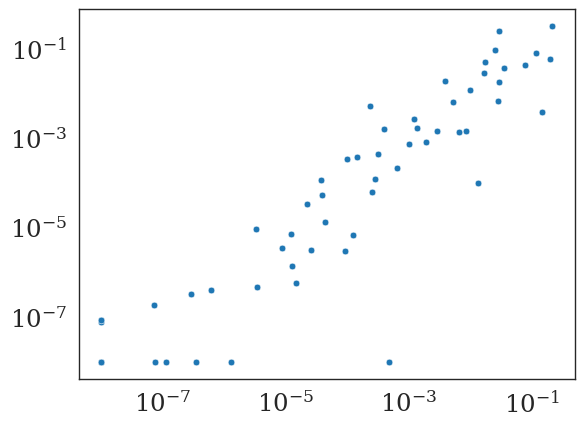

In [27]:
import scipy.stats


x = df_speciesAbun.iloc[:, 1].values.copy()
y = df_speciesAbun.iloc[:, 2].values.copy()
plt_ = sns.scatterplot(x=x, y=y)
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)
print(scipy.stats.pearsonr(np.log10(x), np.log10(y)))

In [28]:
np.arange(len(species_names))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62])

In [29]:
# set fixed params for all analysis
id_species_keep = np.arange(len(species_names))
num_species = len(species_names)
num_metabs = len(metab_names)
num_passages = 6
num_bioRep = 3
df_speciesAbun_mdl = df_speciesAbun.copy()
df_speciesAbun_prev_mdl = df_speciesAbun_prev.copy()
df_speciesAbun_next_mdl = df_speciesAbun_next.copy()
df_speciesAbun_ratio_mdl = df_speciesAbun_ratio.copy()

# 1. Clustering metabolite consumption matrix

In [30]:
# If you want to cluster the metabolites on your own uncomment the following and run
# nclusts = 10
# df_metabs_clusters, df_speciesMetab_new, df_speciesMetab_prod_new = \
#     get_metabs_clusters(df_speciesMetab.copy(), df_speciesMetab_prod.copy(), \
#                         bin_thresh=0.3, species_num_thresh=5, \
#                         n_clusters_hclust=nclusts, distance_metric="euclidean", \
#                         method_cluster="ward", normalize_=False)
# df_speciesMetab_cluster, df_speciesMetab_prod_cluster = \
#     avg_consumption_df(df_speciesMetab_new, df_speciesMetab_prod_new, df_metabs_clusters, \
#                        metab_cluster_mean_func="geometric")

# # ensure matebolite clusters are numbered starting from 1 and not 0
# metab_cluster_names = []
# for m_ in range(df_speciesMetab_cluster.shape[1]):
#     metab_cluster_names.append(f'{m_ + 1}')

# df_speciesMetab_cluster_tmp = df_speciesMetab_cluster.copy()
# df_speciesMetab_cluster.columns = metab_cluster_names

Supplementary Figure S2: Hierarchically clustered heatmap of the consumption fluxes $c_{\alpha\, i}$ for the 10 non-singleton clusters

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

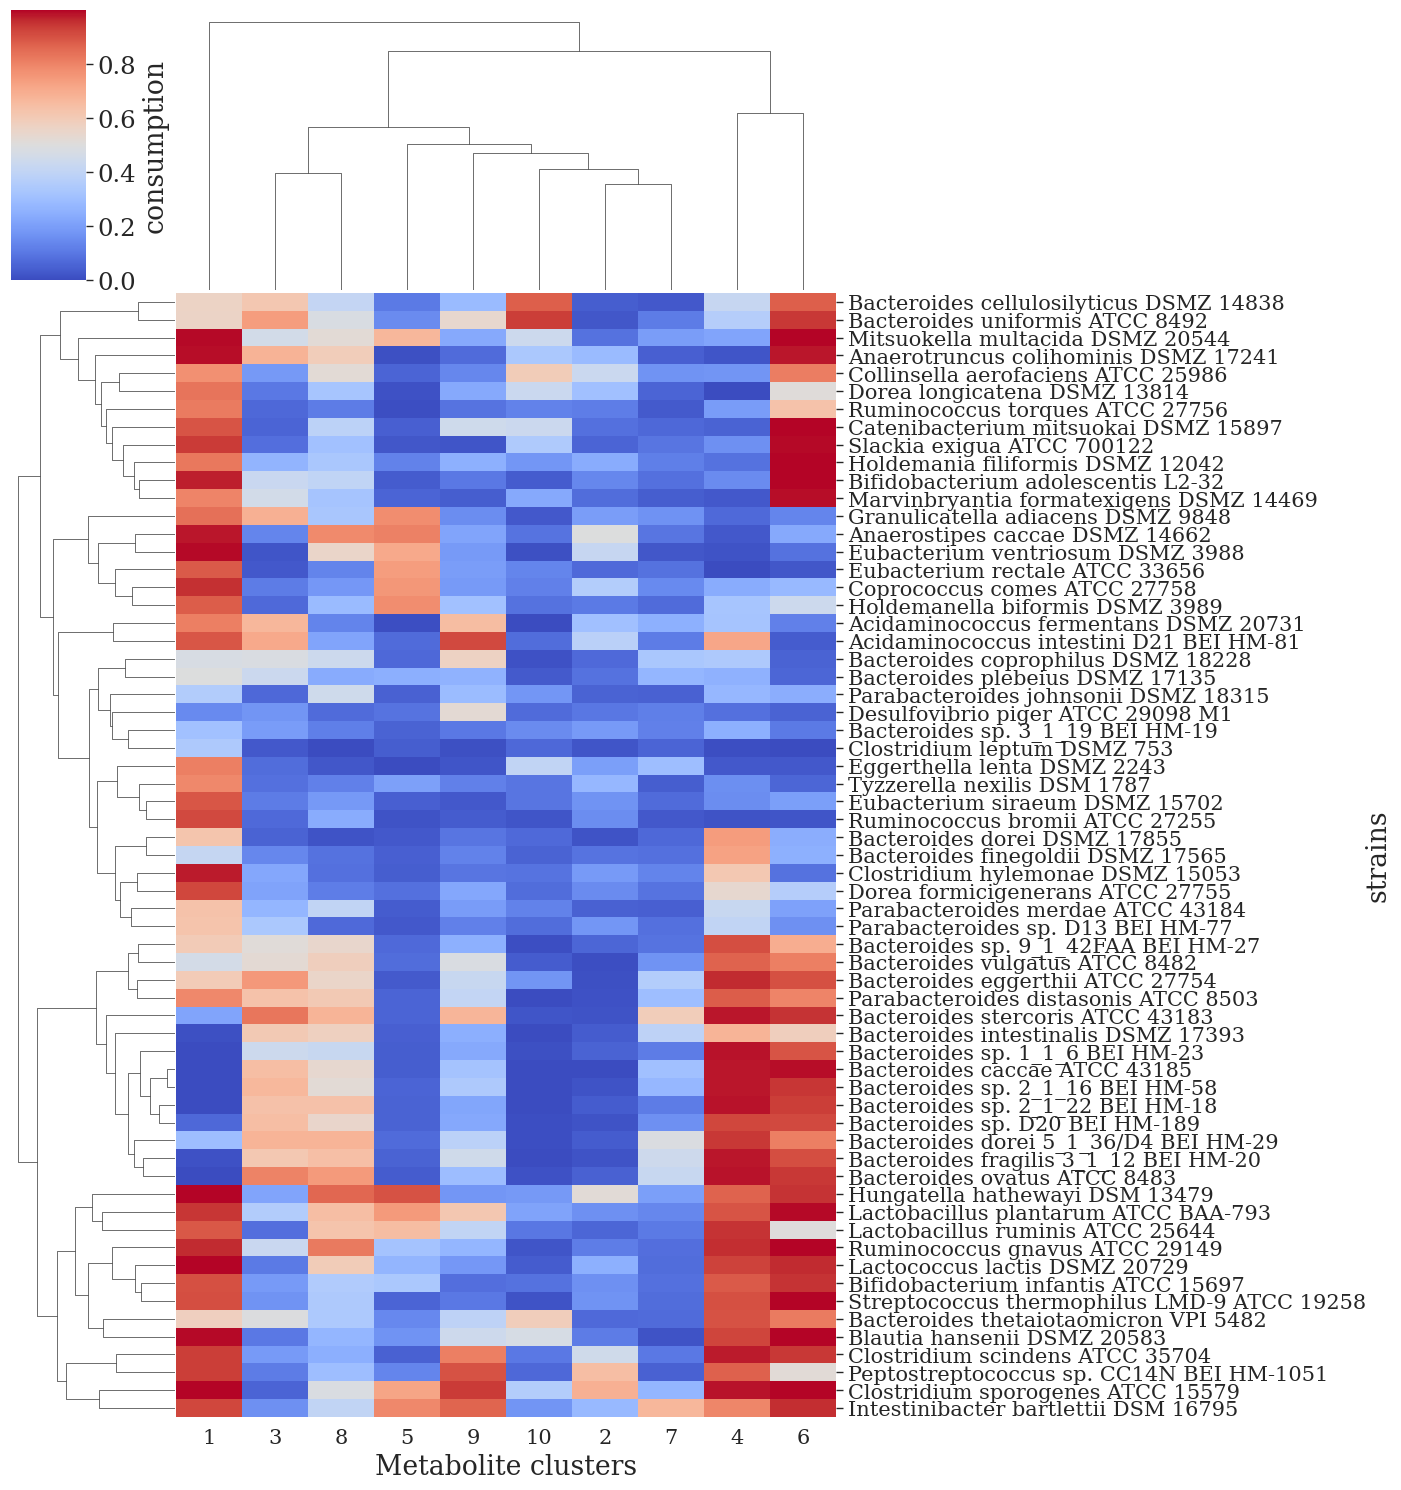

In [31]:
nclusts = 10
distance_metric = 'euclidean'
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
plt.rc('font', family='serif')

plt_ = sns.clustermap(df_speciesMetab_cluster.iloc[:, range(nclusts)], \
                      cmap="coolwarm", figsize=(15, 15), \
                      metric=distance_metric, xticklabels=True, yticklabels=True, \
                      cbar_kws={'shrink': 0.1, 'label': 'consumption'})

plt_.ax_heatmap.set_xlabel('Metabolite clusters')
plt_.ax_heatmap.set_ylabel('strains', labelpad=-1)

plt.setp(plt_.ax_heatmap.get_xticklabels(), rotation=0, fontsize=15)
plt.setp(plt_.ax_heatmap.get_yticklabels(), rotation=0, fontsize=15)
                           
# if want to save the plot as a figure provide a path to save the figure as a .svg
# file in the file_save variable
# plt_.savefig(file_save, \
#                     dpi=300, transparent=False, facecolor="white")


# 2. Fit metabolite concentrations $R_i$ using species abundances for passages 1 and 2 ($N_{\alpha}(\text{end of cycle}\, 1)$ and $N_{\alpha}(\text{end of cycle}\, 2)$, respectively)

2.1 If you want to re-compute the fitting of $R_i$ start from here. Otherwise, to use our provided fits of $R_i$, proceed to **section 2.3**. 

First fit $R_i$ with cross feeding term in Eq. (3) to get an initial estimate of $R_i$. We first assume that $N_{\alpha}(\text{grown alone}) = 0.1$

In [72]:
# Only do this if you want to fit R_i yourself. Otherwise, you can load our fitted R_i as shown in section 2.3

#####uncomment to fit Ri yourself
# rand_seed = 7363
# np.random.seed(rand_seed)
# p_vec_new = [0.1] # this is one minus the time fraction. p = 1 - f. We use f = 0.9 in the manuscript

# N_alone = 0.1 # N_{\alpha}(\text{grown alone})
# num_metabs_clust = df_speciesMetab_cluster.shape[1]
# df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
# df_speciesMetab_prod_tmp = df_speciesMetab_prod_cluster.copy()


# save_data = False
# num_passages = 6
# num_transitions = num_passages - 1

# # passages transitions to remove for fitting R_i. There are 5 passage transitions for 6 passages.
# # we only keep the first transition. Passages are indexed starting from 0 as is the python convention.
# pass_rm = np.arange(1, num_passages - 1)
# Ri_dynamic_obj, A_train, b_train = fit_dynamic_Ri(df_speciesMetab_tmp, \
#                                 df_speciesAbun_prev.copy(), \
#                                 df_speciesAbun_next.copy(), \
#                                 df_speciesAbun_ratio.copy(), p_vec_new, \
#                                 file_save=None, num_passages=num_transitions, pass_rm=pass_rm, num_brep=3, \
#                                 get_prod=True, B_alone=N_alone, \
#                                 df_speciesMetab_prod=df_speciesMetab_prod_tmp, \
#                                 prod_use_prev=False, use_dilution_term=True, \
#                                 dilution_factor=15000, use_avg_for_prod=False, \
#                                 return_raw_data=True, check_ratio_dir=False, save_data=save_data)

####BEGIN: Save fitted R_i. For saving data uncomment the following lines
# save_data = True
# save_dir = {give your own path for saving data here}
# file_save = os.path.abspath(os.path.join(save_dir, 
#                                          f'Ri_fit_dynamic_with_production' + \
#                                          f'_cluster_metabolites_hierachClust_' + \
#                                          f'.pickle'))
# with open(file_save, "wb") as file_:
#      pickle.dump(Ri_dynamic_obj, file_) 
####END: Save data.



2.2 Now, iteratively estimate $R_i$ and $N_{\alpha}(\text{grown alone})$ using the species abundance data for the first two passages.$B_{alone}$ and $N_{alone}$ are used synonymously.

In [73]:
# fit Ri with production and iteratively find B_alone

#####uncomment to fit Ri yourself
# num_iter = 100
# N_alone_iter = {}

# rand_seed = 7363
# np.random.seed(rand_seed)
# p_vec_new = [0.1]
# count_p = 0

# # initialize Ri_0
# Ri_noMicrocosm_dynamicAll_fit_joint = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'].copy()
# count_p = 0
# Ri_0_init_new = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()

# num_metabs_clust = df_speciesMetab_cluster.shape[1]
# df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
# df_speciesMetab_prod_tmp = df_speciesMetab_prod_cluster.copy()

# Ri_dynamic_obj = {}
# num_passages = 6
# num_passage_transitions = num_passages - 1
# pass_keep = np.arange(num_passage_transitions)
# id_keep = list(pass_keep) + list(pass_keep + num_passage_transitions) + \
#     list(pass_keep + 2 * (num_passage_transitions))
# pass_rm = np.arange(1, num_passage_transitions)

# RMSE_Balone_iterate = {}
# id_species_keep = np.arange(df_speciesAbun_mdl.shape[0])

# for iter_ in range(num_iter):
#     print(f'iteration = {iter_}')
#     if iter_ == 0:
#         Ri_avg = Ri_0_init_new.copy()
        
#         # use approximation from the paper to get N_alone once R_i is known
#         N_alone_cur = get_B_alone_func(Ri_avg, \
#                                        df_speciesMetab_cluster.iloc[id_species_keep, :].copy())
#     else:
#         Ri_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'][0].copy()
#         N_alone_cur = N_alone_iter[iter_ - 1].copy()
    
    
#     Ri_dynamic_obj, A_train, b_train = fit_dynamic_Ri(df_speciesMetab_tmp.iloc[id_species_keep, :], \
#                                     df_speciesAbun_prev.iloc[:, id_keep].copy(), \
#                                     df_speciesAbun_next.iloc[:, id_keep].copy(), \
#                                     df_speciesAbun_ratio.iloc[:, id_keep].copy(), p_vec_new, \
#                                     file_save="", num_passages=num_passage_transitions, \
#                                     pass_rm=pass_rm, save_data=False, \
#                                     num_brep=3, \
#                                     get_prod=True, B_alone=N_alone_cur, \
#                                     df_speciesMetab_prod=df_speciesMetab_prod_tmp.iloc[id_species_keep, :], \
#                                     prod_use_prev=False, use_avg_for_prod=False, \
#                                     return_raw_data=True, check_ratio_dir=False)
#     Ri_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'][0].copy()
#     N_alone_iter[iter_] = get_B_alone_func(Ri_avg, \
#                                            df_speciesMetab_cluster.iloc[id_species_keep, :].copy())
#     RMSE_Balone_iterate[iter_] = \
#         get_RMSE_Balone_func(df_speciesMetab_cluster.iloc[id_species_keep, :], \
#                              df_speciesMetab_prod_cluster.iloc[id_species_keep, :], \
#                              p_vec_new, 0, \
#                         Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'].copy(), \
#                         df_speciesAbun_inoc.iloc[id_species_keep, :], \
#                              df_speciesAbun_mdl, df_speciesAbun_prev_mdl, \
#                         df_speciesAbun_ratio_mdl, N_alone_cur, num_passages=6, \
#                         use_dilution=True)
# Ri_dynamic_obj['B_alone_iter'] = N_alone_iter #B_alone and N_alone are used synonymously

# BEGIN: to save the data uncomment the following lines
# save_dir = {path to directory where you want to save the data}
# file_save = os.path.abspath(os.path.join(save_dir, 
#                                          f'for_paper_Ri_fit_dynamic_with_production' + \
#                                          f'_cluster_metabolites_hierachClust' + \
#                                          f'_iterate_Nalone.pickle'))
# with open(file_save, "wb") as file_:
#      pickle.dump(Ri_dynamic_obj, file_) 

2.3 Using the estimated $R_i$ and $N_{\alpha}(\text{grown alone})$, run the dynamical model in forward starting from the inoculum

In [32]:
Ri_noMicrocosm_dynamicAll_fit_all = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_all']
Ri_noMicrocosm_dynamicAll_fit_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_avg']
Ri_noMicrocosm_dynamicAll_fit_joint = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint']
N_alone_iter = Ri_dynamic_obj['B_alone_iter']

In [33]:
id_species_keep

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62])

In [34]:
# evalute Ri with production and iterative Nalone to predict abundances starting with inoculum
num_iter = 100
num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
df_speciesMetab_prod_tmp = df_speciesMetab_prod_cluster.copy()
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
count_p = 7
# num_iter = 20
p_vec_new_tmp = [p_vec_new[count_p]]
count_p = 0

RMSE_mat_full = np.zeros((num_passages - 1, 2))
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
Ri_fit = {0: Ri_avg}
# Ri_fit = {0: Ri_pass1.copy()}
# Ri_0 = {0: Ri_inoc.copy()}
abun_alone = get_B_alone_func(Ri_avg, df_speciesMetab_cluster.iloc[id_species_keep, :].copy())
# RMSE_sens_complete_full = np.zeros((num_passages - 1, 2))
sens_obj_all_prod, RMSE_obj_all_prod = \
    blindly_pred_abun_growth([p_vec_new_tmp[count_p]], \
                             df_speciesMetab_tmp.iloc[id_species_keep, :], \
                             df_speciesAbun_inoc.iloc[id_species_keep, :].copy(), \
                             df_speciesAbun_mdl.copy(), \
                             df_speciesAbun_prev_mdl.copy(), \
                             df_speciesAbun_ratio_mdl.copy(), \
                             Ri_fit.copy(), "dummy", "dummy", \
                             "dummy", num_passages=6, num_iter=100, \
                             thresh_zero=1e-8, Ri_ss=False, plot_=False, \
                             save_data_obj=False, \
                             return_sensitivity_ana=True, \
                             get_prod=True, B_alone=N_alone_iter[num_iter - 2].copy(), \
                             df_speciesMetab_prod=df_speciesMetab_prod_tmp.iloc[id_species_keep, :], \
                             prod_use_prev=False, use_dilution=True, dilution_factor=15000, \
                             use_avg_for_prod=False, Ri_0=None)
for pass_ in range(num_passages - 1):
    RMSE_mat_full[pass_, 0] = RMSE_obj_all_prod[pass_]["abundance"]
    RMSE_mat_full[pass_, 1] = RMSE_obj_all_prod[pass_]["growth_ratio"]

Fig 2

row = 0, col = 0
RMSE high-mid abundance = 1.2878799835933428
row = 0, col = 1
RMSE high-mid abundance = 0.8146386433371602
row = 0, col = 2
RMSE high-mid abundance = 1.3382395626214993


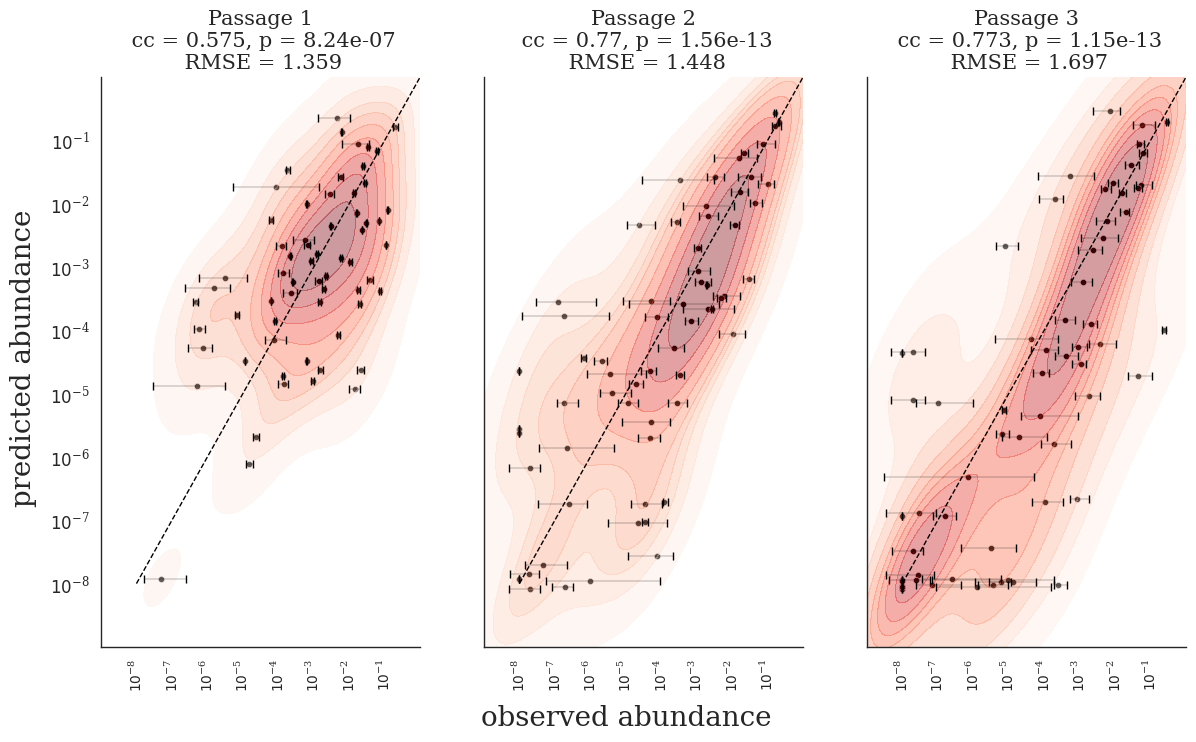

In [35]:
# Figure 2 for paper: prediction performance with production and iterative Balone

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
plt.rc('font', family='serif')

fig, axes = plt.subplots(1, 3, figsize=(14, 7.4), sharey="row", sharex="col")
fig.supylabel('predicted abundance', fontsize=20, x=0.06, y=0.5)
fig.supxlabel('observed abundance', fontsize=20, x=0.5, y=-0.005)
df_pred_vs_obs = pd.DataFrame(data={'passage' : [], \
                                    'species' : [], \
                                    'predicted_abundance' : [], \
                                    'mean_observed_abundance' : [], \
                                    'min_observed_abundance' : [], \
                                    'max_observed_abundance' : []})
max_to_min_pass = [None] * 3
abun_pred_pass = [None] * 3
abun_linear_pred_pass = [None] * 3
abun_orig_pass = [None] * 3
abun_orig_pass_rep = [None] * 3
sd_orig_pass = [None] * 3
RMSE_pred = [None] * 3
for pass_ in range(3):
    ax_row_ = int(pass_ / 3)
    ax_col_ = int(pass_ % 3)
    print(f'row = {ax_row_}, col = {ax_col_}')

    b_ = range(3)
    x_f = sens_obj_all_prod[pass_]['df_speciesAbun_next_obs'].copy()
    x_f = x_f.flatten()
    y_f = sens_obj_all_prod[pass_]['df_speciesAbun_next_pred'].copy()
    thresh_zero = 1e-8
    y_f[y_f <= thresh_zero] = thresh_zero
    x_f[x_f <= thresh_zero] = thresh_zero

    x = np.zeros((num_species))
    x_min = np.zeros((num_species))
    x_max = np.zeros((num_species))
    y = np.zeros((num_species))
    sd_orig_pass[pass_] = np.zeros((num_species))
    RMSE_pred[pass_] = np.zeros((num_species))
    abun_linear_pred_pass[pass_] = np.zeros((num_species))
    abun_orig_pass_rep[pass_] = np.zeros((num_species, 3))
    for rep_ in range(3):
        id_ = np.arange(num_species) * 3 + rep_
        abun_orig_pass_rep[pass_][:, rep_] = np.log10(x_f[id_])
    for species_ in range(num_species):
        id_ = np.array([0, 1, 2]) + species_ * 3
        x[species_] = np.exp(np.mean(np.log(x_f[id_])))
        x_min[species_] = np.min(x_f[id_])
        x_max[species_] = np.max(x_f[id_])
        y[species_] = np.exp(np.mean(np.log(y_f[id_])))
        abun_linear_pred_pass[pass_][species_] = np.mean(x_f[id_])

        sd_orig_pass[pass_][species_] = np.sqrt(np.var((x_f[id_])))
        RMSE_pred[pass_][species_] = np.sqrt(np.mean(np.power(np.log10(x_f[id_]) - \
                                                    np.log10(y_f[id_]), 2)))
        
    x = np.log10(x)
    x_min = np.log10(x_min)
    x_max = np.log10(x_max)
    y = np.log10(y)
    y_orig = y.copy()
    
    id_filter = np.where(x >= -3)[0]
    RMSE_tmp = np.sqrt(np.mean(np.power(y_orig[id_filter] - x[id_filter], 2)))
    print(f'RMSE high-mid abundance = {RMSE_tmp}')
    
    id_ = np.where(y <= -7.99)[0]
    noise_ = np.random.choice([-4, -3, -2, -1, 0, 1, 2, 3, 4], len(id_), replace=True)
    y[id_] += noise_ / 50
    
    df_pred_vs_obs_tmp = pd.DataFrame(data={'passage' : [pass_] * len(x), \
                                      'species' : species_names[:].flatten(), \
                                      'predicted_abundance (log10)' : y, \
                                      'mean_observed_abundance (log10)' : x, \
                                      'min_observed_abundance (log10)' : x_min, \
                                      'max_observed_abundance (log10)' : x_max})
    max_to_min_pass[pass_] = x_max.copy() - x_min.copy()
    abun_pred_pass[pass_] = y_orig.copy()
    abun_orig_pass[pass_] = x.copy()
    if pass_ == 0:
        df_pred_vs_obs = df_pred_vs_obs_tmp.copy()
    else:
        df_pred_vs_obs = pd.concat((df_pred_vs_obs, df_pred_vs_obs_tmp), axis=0)
    
    def error_bar_(x):
        return (np.min(x), np.max(x))

    plt_ = sns.scatterplot(x=x, \
                            y=y, s=20, ax=axes[ax_col_], c="black")
    xerr=np.vstack([x_max.flatten() - x.flatten(), \
                    x.flatten() - x_min.flatten()])
    xerr[xerr < 0] = 0
    axes[ax_col_].errorbar(x=x, y=y, yerr=None, \
                                    xerr=xerr, \
                                   fmt='none', elinewidth=0.2, c="black", \
                          capsize=3)

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.4, cmap="Reds", \
                    ax=axes[ax_col_])
    plt_.plot([-8, 0], [-8, 0], c="black", linewidth=1, ls="dashed")

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y_orig)
    corr_val_pe_log = scipy.stats.pearsonr(x, y_orig)
    corr_val_sp = scipy.stats.spearmanr(x, y_orig)
    # abs_mean_error = np.median(np.abs(y - x))
    abs_mean_error = np.sqrt(np.mean(np.power(y_orig - x, 2)))
    std_error = np.sqrt(np.std(np.power(y_orig - x, 2)))

    id_notzero_zero = np.where((x > -8) & (y <= -8))[0]

    frac_zero = len(id_notzero_zero) / len(x)

    model = sm.OLS(10**y_orig, 10**x).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]

    model_log = sm.OLS(y, x).fit()
    slope_log = model_log.params[0]
    slope_log_pval = model_log.pvalues[0]

    title_ = f'Passage {pass_ + 1}' + \
            f'\n cc = {np.round(corr_val_pe_log[0], 3)}, p = ' + \
                    '{:.2e}'.format(corr_val_pe_log[1]) + \
            f'\n RMSE = {np.round(abs_mean_error, 3)}'

    axes[ax_col_].set_title(title_, size=15)
#     if ax_row_ == 1:
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
    if ax_col_ == 0:
        yticks_ = np.arange(-8, 0, step=1)
        ylabs_ = []
        for y_ in yticks_:
            ylabs_.append(fr"${10}^{{\mathregular{{{y_}}}}}$")
        plt_.set_yticks(yticks_, labels=ylabs_, fontsize=12)
#         plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=9)
    if ax_row_ == 0:
        xticks_ = np.arange(-8, 0, step=1)
        xlabs_ = []
        for x_ in xticks_:
            xlabs_.append(fr"${10}^{{\mathregular{{{x_}}}}}$")
#             plt_.set_yticks(yticks_, labels=ylabs_, fontsize=12)
        plt_.set_xticks(xticks_, labels=xlabs_, fontsize=10)
        axes[ax_col_].tick_params(axis='x', rotation=90) 
#         plt_.set_yticklabels(plt_.get_yticklabels(), fontsiz
#         plt_.set_xticks(np.arange(-10, 1, step=2))
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=9)
    axes[ax_col_].set_xlim(-9, 0)
    axes[ax_col_].set_ylim(-9, 0)
        
    plt_ = sns.despine(right=True, top=True, ax=axes[ax_col_])

Fig. S4

corr at pass = 0
len id = 63
PearsonRResult(statistic=-0.48366978300368224, pvalue=5.925975598130087e-05)
SignificanceResult(statistic=-0.46222158218125964, pvalue=0.0001369107160092578)
corr at pass = 1
len id = 59
PearsonRResult(statistic=-0.4244559947203456, pvalue=0.0008066863168454022)
SignificanceResult(statistic=-0.47469316189362953, pvalue=0.00014554243844205162)
corr at pass = 2
len id = 56
PearsonRResult(statistic=-0.5152865915711847, pvalue=4.828191843395988e-05)
SignificanceResult(statistic=-0.6671223513328777, pvalue=1.9730305095844888e-08)


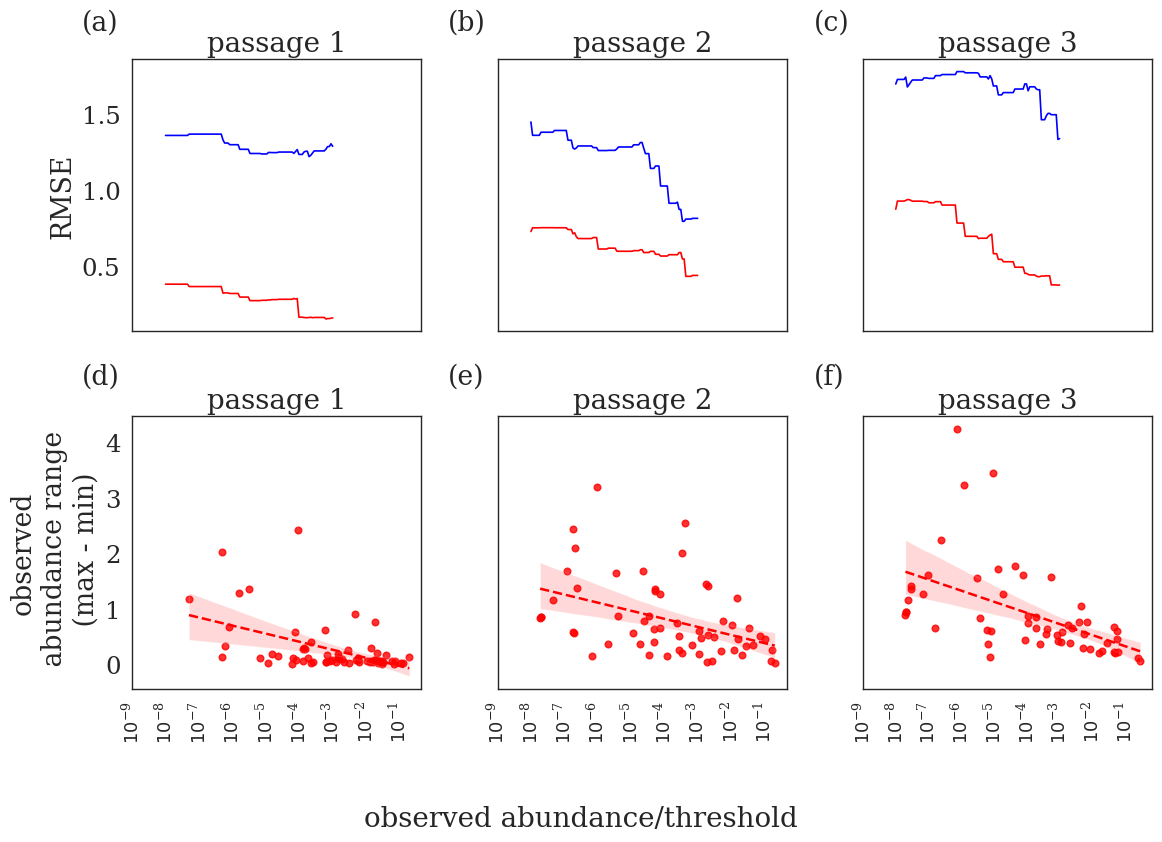

In [31]:
# FIG. S4. Biological replicate-to-replicate variability and model performance are negatively correlated with strain
# abundances in hCom2
pass_ = 2
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
plt.rc('font', family='serif')

fig, axes = plt.subplots(2, 3, figsize=(12, 8.5), sharey="row", sharex="col")
fig.supxlabel('observed abundance/threshold', fontsize=20, x=0.5, y=-0.005)
abun_thresh = np.linspace(-8, -3, 100)
RMSE_pred_vs_org = np.zeros(3)
RMSE_org_rep = np.zeros(3)

for pass_ in np.arange(3):
    x_filter = abun_orig_pass[pass_].copy()
    x = abun_orig_pass[pass_].copy()
    y = max_to_min_pass[pass_].copy()
    id_ = np.where((x >= -8.8) & (y != 0))[0]
    id_species_keep = id_.copy()
    x = x[id_]
    y = y[id_]
    # plt_ = sns.scatterplot(x=x, y=y)
    plt_ = sns.regplot(x=x, y=y, \
                       line_kws={'linestyle' : 'dashed'}, ax=axes[1][pass_], \
                        color='red')
    # axes[0][pass_].axhline(y=1, c="black", linestyle='dotted')

    # axes[0][pass_].axvline(x=-4, c="black", linestyle='dotted')
    # axes[0][pass_].axvline(x=-5, c="black", linestyle='dotted')
    print(f'corr at pass = {pass_}')
    print(f'len id = {len(id_)}')
    print(scipy.stats.pearsonr(x, y))
    print(scipy.stats.spearmanr(x, y))
    
    x = abun_orig_pass[pass_].copy()
    y = abun_pred_pass[pass_].copy()
    y_tmp = max_to_min_pass[pass_].copy()

    RMSE_pred_vs_org[pass_] = np.sqrt(np.mean(np.power(x - y, 2.0)))
    RMSE_org_tmp = 0
    for i_ in range(2):
        for j_ in np.arange(i_ + 1, 3):
            a_ = abun_orig_pass_rep[pass_][:, i_]
            b_ = abun_orig_pass_rep[pass_][:, j_]
            RMSE_org_tmp += np.sqrt(np.mean(np.power(a_[:] - b_[:], 2.0)))
    RMSE_org_tmp /= 3
    RMSE_org_rep[pass_] = RMSE_org_tmp
    
    RMSE_over_thresh = np.zeros(len(abun_thresh))
    max_to_mon_over_thresh = np.zeros(len(abun_thresh))
    RMSE_orig_thresh = np.zeros(len(abun_thresh))
    for count_, thresh_ in enumerate(abun_thresh):
        id_ = np.where(x_filter >= thresh_)[0]
        RMSE_over_thresh[count_] = np.sqrt(np.mean(np.power(x[id_] - y[id_], 2.0)))
        max_to_mon_over_thresh[count_] = np.mean(y_tmp[id_])
        RMSE_org_tmp = 0
        for i_ in range(2):
            for j_ in np.arange(i_ + 1, 3):
                a_ = abun_orig_pass_rep[pass_][:, i_]
                b_ = abun_orig_pass_rep[pass_][:, j_]
                RMSE_org_tmp += np.sqrt(np.mean(np.power(a_[id_] - b_[id_], 2.0)))
        RMSE_org_tmp /= 3
        RMSE_orig_thresh[count_] = RMSE_org_tmp
    plt_ = sns.lineplot(x=abun_thresh, y=RMSE_over_thresh, sort=False, \
                        ax=axes[0][pass_], c='blue')
    plt_ = sns.lineplot(x=abun_thresh, y=RMSE_orig_thresh, sort=False, \
                        ax=axes[0][pass_], c="red")
    # plt_ = sns.lineplot(x=abun_thresh, y=RMSE_over_thresh - RMSE_orig_thresh, sort=False, \
    #                 ax=axes[0][pass_], c="green", linestyle="dashed")
    
    xticks_ = np.arange(-9, 0, step=1)
    xlabs_ = []
    for x_ in xticks_:
        xlabs_.append(fr"${10}^{{\mathregular{{{x_}}}}}$")
#             plt_.set_yticks(yticks_, labels=ylabs_, fontsize=12)
    axes[1][pass_].set_xticks(xticks_, labels=xlabs_, fontsize=13)
    axes[1][pass_].tick_params(axis='x', rotation=90) 
    
    if pass_ == 0:
        axes[1][pass_].set_ylabel(f'observed\n abundance range\n (max - min)')
        
        axes[0][pass_].set_ylabel('RMSE')

    axes[0][pass_].set_title(f'passage {pass_ + 1}', size=20)
    axes[1][pass_].set_title(f'passage {pass_ + 1}', size=20)

for i, ax in enumerate(axes.flatten()):
    if i <= 2:
        ax.text(-10.5, 2.05, f"({string.ascii_lowercase[i]})")
    else:
        ax.text(-10.5, 5.05, f"({string.ascii_lowercase[i]})")
plt.tight_layout()

Fig S3

[1.35919543 1.44773543 1.6969281 ]
[0.38217627 0.72821592 0.87488366]
[0.97701916 0.71951951 0.82204445]


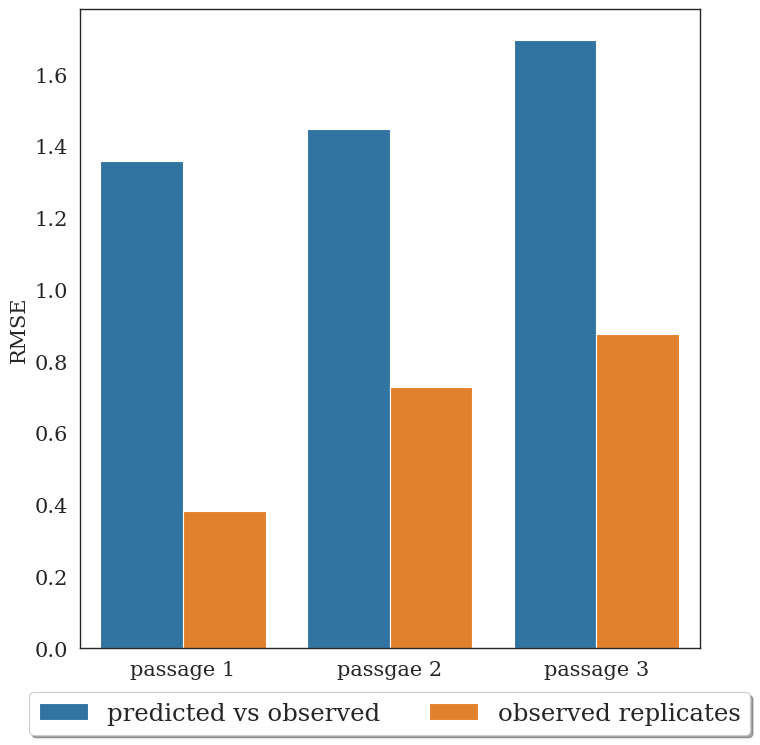

In [39]:
# FIG. S3. Biological replicate-to-replicate variability explains more than half of the residual error in our model
# predictions for hCom2.

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
plt.rc('font', family='serif')
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.rcParams['figure.figsize'] = [8, 8.3]

x = ['passage 1', 'passgae 2', 'passage 3']
x += x
y = np.concatenate((RMSE_pred_vs_org, RMSE_org_rep))
z = np.concatenate((['predicted vs observed'] * 3, ['observed replicates'] * 3))
plt_ = sns.barplot(x=x, y=y, hue=z)
print(RMSE_pred_vs_org)
print(RMSE_org_rep)
print(RMSE_pred_vs_org - RMSE_org_rep)
plt_.set_ylabel('RMSE', fontsize=15)
plt_.set_xlabel(None)
# plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=15)
plt_.legend(loc='upper center', \
            bbox_to_anchor=(0.5, -0.05), ncol=2, fancybox=True, shadow=True)

# 3. First in silico perturbation experiment: leave one out (LOO) strain

In [41]:
def species_mean(id_species_full, x, y, num_species):
    x_mean = np.zeros((num_species))
    y_mean = np.zeros_like(x_mean)
    
    for s_ in range(num_species):
        id_ = np.where(id_species_full == s_)[0]
        x_mean[s_] = np.exp(np.mean(np.log(x[id_])))
        y_mean[s_] = np.exp(np.mean(np.log(y[id_])))
        
    return x_mean, y_mean

In [42]:
def find_perturbed_species(x, y, thresh_=1):
    id_species = np.where(np.abs(np.log10(x) - np.log10(y)) >= thresh_)[0]
    id_species_type = np.zeros((len(id_species)))
    id_species_type[(np.log10(x) - np.log10(y))[id_species] < 0] = 1
    
    return id_species, id_species_type

In [43]:
def normalize_columns(df_):
    for col_ in df_.columns.values:
        df_[col_] /= np.sum(df_[col_].values)
    return df_

In [44]:
def bray_curtis_dist(x1, x2):
    return 1 - np.sum(np.minimum(x1, x2))

def distance_log_ratio(x1, x2, mode_=0):
    diff_ = np.log10(x2.copy() / x1.copy())
    if mode_ == 1:
        diff_[diff_ < 0] = 0
    elif mode_ == 2:
        diff_[diff_ > 0] = 0
    return np.mean(np.abs(diff_))

In [45]:
# perform the LOO strain removal analysis
# with production term and iterative Balone
p_vec_new_tmp = [0.1]
num_iter = 100
pass_keep = remove_passages(pass_rm_list=[0, 1, 3, 4, 5])
abun_avg_pass_3 = np.array(df_speciesAbun_mdl.iloc[:, pass_keep])
abun_avg_pass_3 = np.mean(np.log(abun_avg_pass_3), axis=1)
id_species_order = np.argsort(-abun_avg_pass_3)

RMSE_mat_full = np.zeros((num_passages, 2))

s_ = id_species_order[3]
count_p = 0

id_species_full = np.arange((num_species)).reshape((num_species, 1))
id_species_full = np.hstack([id_species_full, id_species_full, id_species_full]).flatten()
# for count_, s_ in enumerate(id_species_order):


id_rep_keep = np.arange(len(species_names)) * 3
count_keep = 0
abun_pertub_list = [None] * len(species_names)
thresh_zero = 1e-8
dist_ = np.zeros((len(species_names)))
dist_pos = np.zeros((len(species_names)))
dist_neg = np.zeros((len(species_names)))
for count_ in range(len(species_names)):
    abun_pertub_list[count_] = np.zeros(len(species_names))
for count_, s_ in enumerate(id_species_order):
    x = sens_obj_all_prod[2]['df_speciesAbun_next_pred'].copy()
    x[x <= thresh_zero] = thresh_zero
    x_mean = x[id_rep_keep]
    abun_pred = x_mean.copy()
#     if np.abs(np.log10(x_mean[s_]) - np.log10(np.exp(abun_avg_pass_3[s_]))) < 1:
    if True:
        print(f'loop = {count_}, species perturbed = {s_}')
        id_strains_sensitive = set(list(np.arange(num_species))) - \
            set(list([s_]))
        id_strains_sensitive = np.array(list(id_strains_sensitive))
        df_speciesAbun_inoc_tmp = df_speciesAbun_inoc.copy()
        df_speciesAbun_inoc_tmp.iloc[s_, :] = thresh_zero
        df_speciesAbun_inoc_tmp = normalize_columns(df_speciesAbun_inoc_tmp.copy())
        df_speciesAbun_inoc_tmp.iloc[s_, :] = thresh_zero

        df_speciesAbun_tmp = df_speciesAbun_mdl.copy()
        df_speciesAbun_tmp.iloc[s_, :] = thresh_zero
        df_speciesAbun_tmp = normalize_columns(df_speciesAbun_tmp.copy())
        df_speciesAbun_tmp.iloc[s_, :] = thresh_zero

        df_speciesAbun_prev_tmp = df_speciesAbun_prev_mdl.copy()
        df_speciesAbun_prev_tmp.iloc[s_, :] = thresh_zero
        df_speciesAbun_prev_tmp = normalize_columns(df_speciesAbun_prev_tmp.copy())
        df_speciesAbun_prev_tmp.iloc[s_, :] = thresh_zero

        df_speciesAbun_ratio_tmp = df_speciesAbun_ratio_mdl.copy()
        df_speciesAbun_ratio_tmp.iloc[s_, :] = 1

        id_metabs_keep = metabs_to_remove_knockdown_species(df_speciesMetab_cluster, [s_])
        Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
        Ri_avg = Ri_avg[id_metabs_keep]
        Ri_fit = {0: Ri_avg}

        num_metabs_clust = df_speciesMetab_cluster.shape[1] - 1
        df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
        df_speciesMetab_tmp = df_speciesMetab_tmp.iloc[:, id_metabs_keep]
        df_speciesMetab_prod_tmp = df_speciesMetab_prod_cluster.copy()
        df_speciesMetab_prod_tmp = df_speciesMetab_prod_tmp.iloc[:, id_metabs_keep]

        # RMSE_sens_complete_full = np.zeros((num_passages - 1, 2))
        sens_obj_knock, RMSE_obj_knock = \
            blindly_pred_abun_growth([p_vec_new_tmp[count_p]], df_speciesMetab_tmp, \
                                     df_speciesAbun_inoc_tmp, df_speciesAbun_tmp, \
                                     df_speciesAbun_prev_tmp, \
                                     df_speciesAbun_ratio_tmp, \
                                     Ri_fit, "dummy", "dummy", \
                                     "dummy", num_passages=6, num_iter=100, \
                                     thresh_zero=thresh_zero, Ri_ss=False, plot_=False, \
                                     save_data_obj=False, \
                                     return_sensitivity_ana=True, \
                                     get_prod=True, B_alone=N_alone_iter[num_iter - 2], \
                                     df_speciesMetab_prod=df_speciesMetab_prod_tmp, \
                                     prod_use_prev=False, num_passages_run=3, \
                                     use_dilution=True, \
                                     dilution_factor=15000, \
                                     id_species_update=id_strains_sensitive, \
                                     use_avg_for_prod=False)
        y = sens_obj_knock[2]['df_speciesAbun_next_pred'].copy()

        y[y <= thresh_zero] = thresh_zero
    #     x_mean, y_mean = species_mean(id_species_full, x, y, num_species)


        y_mean = y[id_rep_keep]

        x_null = x_mean.copy()
        x_null[s_] = 0
        x_null = x_null / np.sum(x_null)
        x_null[x_null <= thresh_zero] = thresh_zero
        y_mean[y_mean <= thresh_zero] = thresh_zero
        
        print(f'vals = {x_mean[s_]}, {y_mean[s_]}, {x_null[s_]}')
        id_drop_all = np.setdiff1d(np.arange(len(x_null)), np.array([s_]))
        dist_[s_] = distance_log_ratio(x_null[id_drop_all], y_mean[id_drop_all], mode_=0)
        dist_pos[s_] = distance_log_ratio(x_null[id_drop_all], y_mean[id_drop_all], mode_=1)
        dist_neg[s_] = distance_log_ratio(x_null[id_drop_all], y_mean[id_drop_all], mode_=2)

        abun_pertub_list[s_] = y_mean.copy()
        print(f'difference in community sum = {np.sum(y_mean) - np.sum(x_mean)}')
        print(f'knocked-out abundance = {y_mean[s_]}')

        if x_mean[s_] <= 0.01:
            id_species, id_species_type = \
                find_perturbed_species(x_mean, y_mean, thresh_=np.log10([10])[0])
        else:
            id_species, id_species_type = \
                find_perturbed_species(x_mean, y_mean, thresh_=np.log10([10])[0])
        id_species_f, id_species_type_full = \
            find_perturbed_species(x_mean, y_mean, thresh_=0.01)
        if np.abs(np.log10(x_mean[s_]) - np.log10(np.exp(abun_avg_pass_3[s_]))) < 1:
            col_ = "green"
        else:
            col_ = "gray"
        df_perturb_tmp = pd.DataFrame(data={"species_knocked" : [s_] * len(id_species), \
                                            "species_type" : [col_] * len(id_species), \
                                            "species_perturbed" : id_species, \
                                            "species_perturbed_type" : id_species_type, \
                                            "species_unperturbed_abun" : x_mean[id_species], \
                                            "species_perturbed_abun" : y_mean[id_species]})

        df_perturb_full_tmp = pd.DataFrame(data={"species_knocked" : [s_] * len(id_species_f), \
                                        "species_type" : [col_] * len(id_species_f), \
                                        "species_perturbed" : id_species_f, \
                                        "species_perturbed_type" : id_species_type_full, \
                                        "species_unperturbed_abun" : x_mean[id_species_f], \
                                        "species_perturbed_abun" : y_mean[id_species_f]})
        if count_keep == 0:
            df_perturb_net = df_perturb_tmp.copy()
            df_perturb_net_full = df_perturb_full_tmp.copy()
        else:
            df_perturb_net = pd.concat([df_perturb_net, df_perturb_tmp])
            df_perturb_net_full = pd.concat([df_perturb_net_full, df_perturb_full_tmp])
        count_keep += 1
    
    

loop = 0, species perturbed = 1
vals = 0.19337116839249957, 1e-08, 1e-08
difference in community sum = 1.3932047071563147e-08
knocked-out abundance = 1e-08
loop = 1, species perturbed = 8
vals = 0.00010076226682383575, 1e-08, 1e-08
difference in community sum = 1.01747494873905e-08
knocked-out abundance = 1e-08
loop = 2, species perturbed = 22
vals = 0.06404429272915095, 1e-08, 1e-08
difference in community sum = 1.1945595845830326e-08
knocked-out abundance = 1e-08
loop = 3, species perturbed = 23
vals = 0.17796380107559837, 1e-08, 1e-08
difference in community sum = -9.596294869851363e-10
knocked-out abundance = 1e-08
loop = 4, species perturbed = 21
vals = 0.019690284419445703, 1e-08, 1e-08
difference in community sum = 1.1647354636323826e-08
knocked-out abundance = 1e-08
loop = 5, species perturbed = 51
vals = 0.0870468606610599, 1e-08, 1e-08
difference in community sum = -1.981733110945072e-08
knocked-out abundance = 1e-08
loop = 6, species perturbed = 15
vals = 1.878940570880983e-

# Fig. S6

0.19337116839249957
Acidaminococcus-intestini-D21
high abundance strain knock-out
PearsonRResult(statistic=0.9263258434568035, pvalue=4.02242262900803e-27)
2.2821089245886162e-06
Bacteroides-finegoldii-DSM-17565
low abundance strain knock-out
PearsonRResult(statistic=0.9999999291592385, pvalue=3.551820612759866e-207)


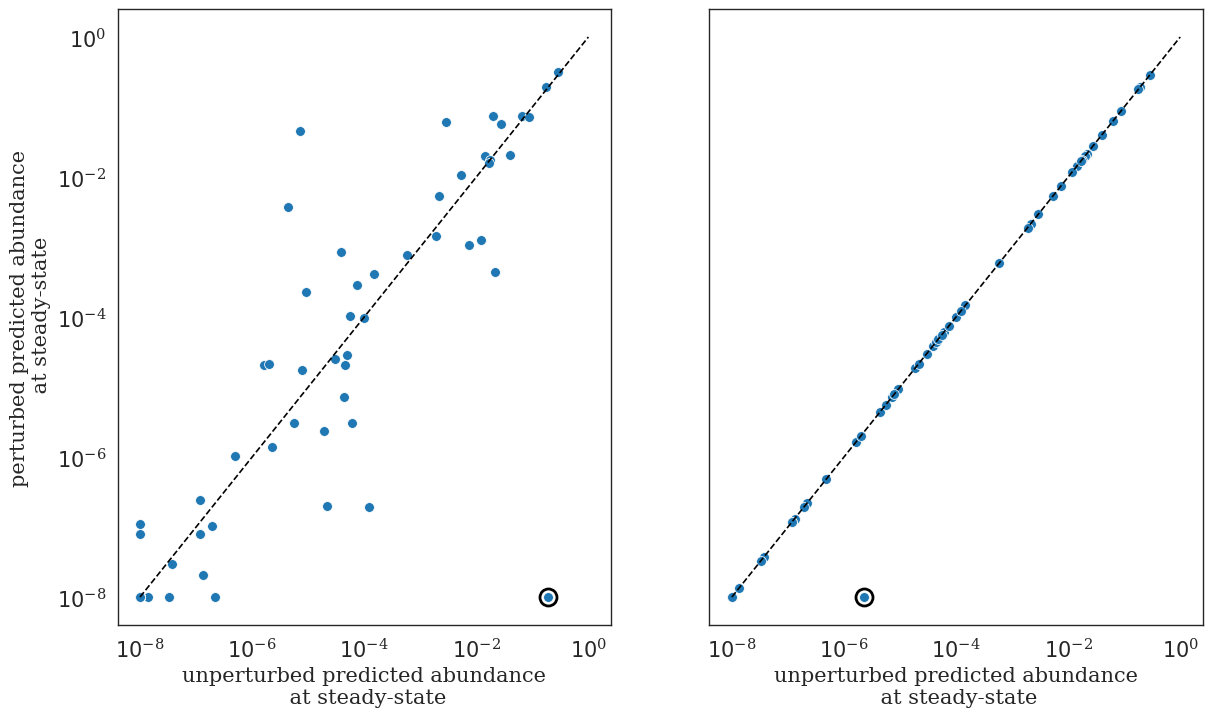

In [46]:
# FIG. S6. Perturbations from leave-one-experiment are non-trivial and cannot be explained by re-normalization
# for relative abundances for hCom2.
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
plt.rc('font', family='serif')
cols_ = sns.color_palette("husl", 8)
# plt.figure(figsize=(10, 10), dpi=300)

num_iter = 100
# fig, axes = plt.subplots(2, int(num_passages / 2), \
#                              figsize=(40, 35), sharey="row", sharex="col")
fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey="row", sharex=None)
abuns_ = abun_avg_pass_3
abuns_ = np.log(abun_pred.copy())
abun_pred_log = np.log(abun_pred.copy())
# plot abundance change
abuns_ = abun_pred_log.copy()

st_ = 1
print(x_mean[st_])
print(species_names[st_])
plt_ = sns.scatterplot(x=[x_mean[st_]], y=[abun_pertub_list[st_][st_]], \
                       ax=axes[0], s=150, linewidth=2, marker='o', edgecolor='black', \
                       color='white')
plt_ = sns.scatterplot(x=(x_mean), y=(abun_pertub_list[st_]), \
                       ax=axes[0], s=50)
axes[0].plot([10.0**-8, 1], [10.0**-8, 1], c="black", linestyle='dashed')
print(f'high abundance strain knock-out')
id_corr = np.array(list(set(list(np.arange(len(species_names)))) - set([st_])))
print(scipy.stats.pearsonr(np.log10(x_mean[id_corr]), np.log10(abun_pertub_list[st_][id_corr])))
axes[0].set_ylabel('perturbed predicted abundance\n at steady-state', fontsize=15)
axes[0].set_xlabel('unperturbed predicted abundance\n at steady-state', fontsize=15)
    
axes[0].set_xscale('log', base=10)
xticks_ = np.arange(-8, 1, step=2)
xlabs_ = []
xticks_pow = []
for x_ in xticks_:
    xlabs_.append(fr"${10}^{{\mathregular{{{x_}}}}}$")
    xticks_pow.append(np.power(10.0, x_))
axes[0].set_xticks(xticks_pow, labels=xlabs_, fontsize=15)

axes[0].set_yscale('log', base=10)
axes[0].set_yticks(xticks_pow, labels=xlabs_, fontsize=15)

    
st_ = 10
print(x_mean[st_])
print(species_names[st_])
plt_ = sns.scatterplot(x=[x_mean[st_]], y=[abun_pertub_list[st_][st_]], \
                       ax=axes[1], s=150, linewidth=2, marker='o', edgecolor='black', \
                       color='white')
plt_ = sns.scatterplot(x=(x_mean), y=(abun_pertub_list[st_]), \
                       ax=axes[1], s=50)
axes[1].plot([10.0**-8, 1], [10.0**-8, 1], c="black", linestyle='dashed')
print(f'low abundance strain knock-out')
id_corr = np.array(list(set(list(np.arange(len(species_names)))) - set([st_])))
print(scipy.stats.pearsonr(np.log10(x_mean[id_corr]), np.log10(abun_pertub_list[st_][id_corr])))
axes[1].set_ylabel('perturbed predicted abundance\n at steady-state', fontsize=15)
axes[1].set_xlabel('unperturbed predicted abundance\n at steady-state', fontsize=15)
    
axes[1].set_xscale('log', base=10)
xticks_ = np.arange(-8, 1, step=2)
xlabs_ = []
xticks_pow = []
for x_ in xticks_:
    xlabs_.append(fr"${10}^{{\mathregular{{{x_}}}}}$")
    xticks_pow.append(np.power(10.0, x_))
axes[1].set_xticks(xticks_pow, labels=xlabs_, fontsize=15)

axes[1].set_yscale('log', base=10)
axes[1].set_yticks(xticks_pow, labels=xlabs_, fontsize=15)

In [49]:
# prepare data frame for strain-strain co-dependency network
pass_keep = remove_passages(pass_rm_list=[0, 1, 3, 4, 5])
abun_avg_pass_3 = np.array(df_speciesAbun_mdl.iloc[:, pass_keep])
abun_avg_pass_3 = np.mean(np.log(abun_avg_pass_3), axis=1)

df_perturb_net['species_abun_obs'] = np.exp(abun_avg_pass_3[df_perturb_net['species_perturbed'].values])
df_perturb_net_full['species_abun_obs'] = np.exp(abun_avg_pass_3[df_perturb_net_full['species_perturbed'].values])

x_obs = df_perturb_net['species_abun_obs'].values
x = df_perturb_net['species_unperturbed_abun'].values
y = df_perturb_net['species_perturbed_abun'].values
col_type = df_perturb_net['species_type'].values
# id_filter = np.where((np.abs(np.log10(x) - np.log10(x_obs)) - np.abs(np.log10(y) - np.log10(x_obs)) <= -1) & \
#                      (col_type == "green"))[0]
# id_filter = np.where((np.abs(np.log10(x) - np.log10(x_obs)) - np.abs(np.log10(y) - np.log10(x_obs)) <= -1))[0]
# id_filter = np.where((np.abs(np.log10(y) - np.log10(x)) >= 2))[0]
id_filter = np.arange(df_perturb_net.shape[0])
df_perturb_net_filter = df_perturb_net.copy()
df_perturb_net_filter = df_perturb_net_filter.iloc[id_filter, :]

print(df_perturb_net_filter.shape)
print(df_perturb_net_full.shape)

(108, 7)
(802, 7)


# Create strain-strain co-dependency network
Without removing the noisy edges from the network. Noisy edges were removed for Fig. 3a but not for Fig.s 3b, and c

In [59]:
df_perturb_net_filter = df_perturb_net_full.copy()
G = nx.DiGraph()
# id_species_order = np.argsort(abun_avg_pass_3)
id_species_order = np.argsort(abun_pred)
species_order = np.zeros(num_species)
species_order[id_species_order] = (np.arange(num_species) / num_species)
# species_order = 8.1 + np.log10(np.exp(abun_avg_pass_3))
# species_order = np.exp(abun_avg_pass_3)
species_order = abun_pred.copy()
col_species = []
for s_ in range(num_species):
    if np.abs(np.log10(x_mean[s_]) - np.log10(np.exp(abun_avg_pass_3[s_]))) < 1:
#         col_ = "gray"
        col_ = "white"
#         G.add_nodes_from([(species_names[s_], {"abundance_obs" : species_order[s_], "node_color" : col_})])
    else:
        col_ = "white"
#     G.add_nodes_from([(species_names[s_], {"abundance_obs" : species_order[s_], "node_color" : col_})])
    G.add_nodes_from([(f'{s_ + 1}', {"abundance_obs" : species_order[s_], "node_color" : col_})])
#     G.add_nodes_from([(f'{df_names_convert.iloc[s_, 1]}', {"abundance_obs" : species_order[s_], "node_color" : col_})])
    col_species.append(col_)
col_species = np.array(col_species)    

In [60]:
red_ = '#e41a1c'
blue_ = '#4daf4a'
perturbed_nodes = {}
perturbed_nodes_col = {}
for row_ in range(num_species):
    perturbed_nodes[row_] = []
    perturbed_nodes_col[row_] = []
for row_ in range(df_perturb_net_filter.shape[0]):
    src_ = df_perturb_net_filter['species_knocked'].values[row_]
    dest_ = df_perturb_net_filter['species_perturbed'].values[row_]
    
    if (src_ != dest_):
        perturbed_nodes[int(src_)].append(int(dest_))
        type_ = df_perturb_net_filter['species_perturbed_type'].values[row_]
        if type_ == 1:
            col_ = red_
        else:
            col_ = blue_
        perturbed_nodes_col[int(src_)].append(col_)
for row_ in range(num_species):
    perturbed_nodes[row_] = np.array(perturbed_nodes[row_])
    perturbed_nodes_col[row_] = np.array(perturbed_nodes_col[row_])

In [61]:
red_ = '#e41a1c'
blue_ = '#4daf4a'
edges_ = []
competition_ = []
cross_feeding = []
competition_with_increased = []
# for row_ in range(num_species):
#     competition_with_increased[row_] = {}
src_abun = []
col_edges = []
col_edges_full = []
count_p = 0
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
zero_thresh_Ri = 1e-8
# Ri_avg[Ri_avg >= zero_thresh_Ri] = 1
Ri_avg[Ri_avg < zero_thresh_Ri] = 0
for row_ in range(df_perturb_net_filter.shape[0]):
    src_ = df_perturb_net_filter['species_knocked'].values[row_]
    dest_ = df_perturb_net_filter['species_perturbed'].values[row_]
    
    if (src_ != dest_):
#     if (src_ != dest_) and (col_species[int(src_)] == "gray") and (col_species[int(dest_)] == "gray"):
        type_ = df_perturb_net_filter['species_perturbed_type'].values[row_]
        if type_ == 1:
            col_ = red_
        else:
            col_ = blue_
        col_edges_full.append(col_)
#         src_abun.append(abun_avg_pass_3[int(src_)])
        src_abun.append(abun_pred[int(src_)])
        vec_src = df_speciesMetab_cluster.iloc[int(src_), :].values
        vec_prod_src = df_speciesMetab_prod_cluster.iloc[int(src_), :].values
        vec_dest = df_speciesMetab_cluster.iloc[int(dest_), :].values
        nnz_dest = len(np.where(Ri_avg * vec_dest != 0)[0])
        nnz_common = len(np.where((Ri_avg * vec_dest * vec_src) != 0)[0])
        tmp = np.sum(Ri_avg * vec_src * Ri_avg * vec_dest) / \
            (np.sqrt(np.sum(np.power(Ri_avg * vec_src, 2))) * \
             np.sqrt(np.sum(np.power(Ri_avg * vec_dest, 2))))
        competition_.append(nnz_common / nnz_dest)
#         competition_.append(tmp)
        
        nnz_dest = len(np.where(Ri_avg * vec_dest != 0)[0])
        nnz_common = len(np.where(Ri_avg * vec_dest * vec_prod_src != 0)[0])
        tmp = np.sum(Ri_avg * vec_prod_src * Ri_avg * vec_dest) / \
            (np.sqrt(np.sum(np.power(Ri_avg * vec_prod_src, 2))) * \
             np.sqrt(np.sum(np.power(Ri_avg * vec_dest, 2))))
        cross_feeding.append(nnz_common / nnz_dest)
#         cross_feeding.append(tmp)

        id_blue = np.where(perturbed_nodes_col[int(src_)] == blue_)[0]
        id_red = np.where(perturbed_nodes_col[int(src_)] == red_)[0]
        
        if (col_ == blue_) and (len(id_red) > 0):
            competition_with_increased_tmp = []
            vec_dest = df_speciesMetab_cluster.iloc[int(dest_), :].values
            nnz_dest = len(np.where(Ri_avg * vec_dest != 0)[0])
            for id_2 in range(len(id_red)):
                src_tmp = perturbed_nodes[int(src_)][id_red[id_2]]
                vec_src = df_speciesMetab_cluster.iloc[src_tmp, :].values
                nnz_common = len(np.where((Ri_avg * vec_dest * vec_src) != 0)[0])
                tmp = np.sum(Ri_avg * vec_src * Ri_avg * vec_dest) / \
                    (np.sqrt(np.sum(np.power(Ri_avg * vec_src, 2))) * \
                     np.sqrt(np.sum(np.power(Ri_avg * vec_dest, 2))))
                competition_with_increased_tmp.append(nnz_common / nnz_dest)
#                 competition_with_increased_tmp.append(tmp)
            competition_with_increased_tmp = np.array(competition_with_increased_tmp)
#                 id_max = \
#                     np.where(competition_with_increased_tmp == \
#                              np.max(competition_with_increased_tmp))[0]
            competition_with_increased.append(np.median(competition_with_increased_tmp))
#             competition_with_increased.append(np.median(np.array(competition_with_increased_tmp)))
        
    if (src_ != dest_):
#     if (src_ != dest_) and (col_species[int(src_)] == "gray") and (col_species[int(dest_)] == "gray"):
#     if (src_ != dest_) and (col_species[int(src_)] == "gray"):
#         print(f'row = {row_}')
        type_ = df_perturb_net_filter['species_perturbed_type'].values[row_]
        if type_ == 1:
            col_ = red_
        else:
            col_ = blue_
        col_edges.append(col_)
#         vec_src = df_speciesMetab_cluster.iloc[int(src_), :].values
#         vec_prod_src = df_speciesMetab_prod_cluster.iloc[int(src_), :].values
#         vec_dest = df_speciesMetab_cluster.iloc[int(dest_), :].values
#         nnz_dest = len(np.where(vec_dest != 0)[0])
#         nnz_common = len(np.where((vec_dest * vec_src) != 0)[0])
#         tmp = np.sum(vec_src * vec_dest) / \
#             (np.sqrt(np.sum(np.power(vec_src, 2))) * np.sqrt(np.sum(np.power(vec_dest, 2))))
# #         competition_.append(nnz_common / nnz_dest)
#         competition_.append(tmp)
        
#         nnz_dest = len(np.where(vec_dest != 0)[0])
#         nnz_common = len(np.where(vec_dest * vec_prod_src != 0)[0])
#         tmp = np.sum(vec_prod_src * vec_dest) / \
#             (np.sqrt(np.sum(np.power(vec_prod_src, 2))) * np.sqrt(np.sum(np.power(vec_dest, 2))))
# #         cross_feeding.append(nnz_common / nnz_dest)
#         cross_feeding.append(tmp)
        
        weight_ = np.abs(np.log10(df_perturb_net_filter['species_unperturbed_abun'].values[row_]) - \
                         np.log10(df_perturb_net_filter['species_perturbed_abun'].values[row_]))
#         edges_.append((species_names[int(src_)], \
#                        species_names[int(dest_)], {'increased abundance': col_, 'weight' : weight_}))
        edges_.append((f'{int(src_ + 1)}', \
                       f'{int(dest_ + 1)}', {'increased abundance': col_, 'weight' : weight_}))
G.add_edges_from(edges_)
competition_ = np.array(competition_)
competition_with_increased = np.array(competition_with_increased)
src_abun = np.array(src_abun)
col_edges = np.array(col_edges)
col_edges_full = np.array(col_edges_full)
# col_edges_full = col_edges.copy()
cross_feeding = np.array(cross_feeding)

In [62]:
# get adjacency matrix
adj_G = np.zeros((num_species, num_species))
edges = G.edges()
nodes_ = G.nodes()
for u,v in edges:
    i = int(u) - 1
    j = int(v) - 1
    if G[u][v]['increased abundance'] == red_:
        adj_G[i, j] = G[u][v]['weight']
    else:
        adj_G[i, j] = -G[u][v]['weight']

# Fig 3b, c

# strains responding to changes = 58
with zeros excluded
corr upregulated = PearsonRResult(statistic=-0.39606966132132837, pvalue=0.0020864680734682278)
with zeros included
corr upregulated = PearsonRResult(statistic=-0.2275821803551336, pvalue=0.07284115193837824)
with zeros excluded
corr downregulated = PearsonRResult(statistic=-0.1309891570542767, pvalue=0.36965093970696783)
with zeros included
corr downregulated = PearsonRResult(statistic=0.21378432095139627, pvalue=0.09249274206398031)


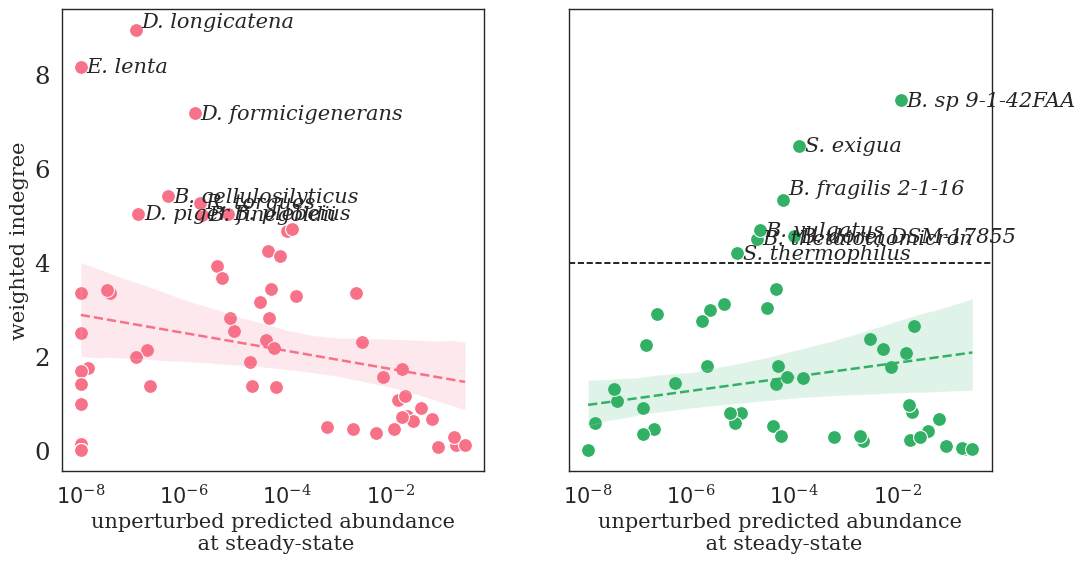

In [63]:
# Figure for paper: prediction performance with production and iterative Balone
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
plt.rc('font', family='serif')
cols_ = sns.color_palette("husl", 8)
# plt.figure(figsize=(10, 10), dpi=300)

num_iter = 100
# fig, axes = plt.subplots(2, int(num_passages / 2), \
#                              figsize=(40, 35), sharey="row", sharex="col")
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey="row", sharex=None)

abuns_ = np.log(abun_pred.copy())
abun_pred_log = np.log(abun_pred.copy())
# in-degree
# up regulation
count_nnz = np.zeros((num_species, num_species))
id_ = np.where((adj_G) > 0)
adj_bin = np.zeros_like(adj_G)
adj_bin[id_] = 1
count_nnz[id_] = np.abs(adj_G)[id_]
num_changes_x = np.sum(count_nnz, axis=0)

# down regulation
count_nnz = np.zeros((num_species, num_species))
id_ = np.where(-(adj_G) > 0)
adj_bin = np.zeros_like(adj_G)
adj_bin[id_] = 1
count_nnz[id_] = np.abs(adj_G)[id_]
num_changes_y = np.sum(count_nnz, axis=0)

id_ = np.where(num_changes_x + num_changes_y != 0)[0]
print(f'# strains responding to changes = {len(id_)}')

# with zeros excluded
print(f'with zeros excluded')
id_nnz_x = np.where((num_changes_x > 0))[0]
# id_nnz_x = np.arange(len(species_names))
# id_ = np.where(p_val_vec_new >= 0.05)[0]
# id_rm = id_low_low[id_]
# id_nnz_x = np.delete(id_nnz_x, id_rm)
corr_tmp = scipy.stats.pearsonr(np.log10(abun_pred[id_nnz_x]), \
                                num_changes_x[id_nnz_x])
print(f'corr upregulated = {corr_tmp}')

# with zeros included
print(f'with zeros included')
id_nnz_x = np.where((num_changes_x >= 0))[0]
id_nnz_x = np.arange(len(species_names))
# id_nnz_x = np.delete(id_nnz_x, id_indeg_rm)
corr_tmp = scipy.stats.pearsonr(np.log10(abun_pred[id_nnz_x]), \
                                num_changes_x[id_nnz_x])
print(f'corr upregulated = {corr_tmp}')
# id_nnz_x = np.arange(len(species_names))
id_nnz_ = np.where((num_changes_x > 0) | (num_changes_y > 0))[0]
plt_ = sns.scatterplot(x=np.log10(np.exp(abun_pred_log[id_nnz_x])), \
                       y=num_changes_x[id_nnz_x], ax=axes[0], s=100, \
                       color=cols_[0])
plt_ = sns.regplot(x=(np.log10(np.exp(abun_pred_log[id_nnz_x]))), \
                   y=num_changes_x[id_nnz_x], ax=axes[0], scatter=False, \
                   color=cols_[0], line_kws={'linestyle':'dashed'})

axes[0].set_ylabel('weighted indegree', fontsize=15)
axes[0].set_xlabel(f'unperturbed predicted abundance\n at steady-state', fontsize=15)

id_sort = np.argsort(-num_changes_x[id_nnz_x])
# print(num_changes_y[id_nnz_[id_sort]])
size_ = 8
# axes[0].axhline(y=num_changes_x[id_nnz_x[id_sort[size_ - 1]]] - 0.2, \
#                 c='black', linestyle='dashed')
labels = species_names_abbr[id_nnz_x[id_sort[range(size_)]]]
x = np.log10(np.exp(abun_pred_log[id_nnz_x[id_sort[range(size_)]]]))
y = (num_changes_x[id_nnz_x[id_sort[range(size_)]]])
for i, label in enumerate(labels):
    if i != 0:
        axes[0].annotate(label, (x[i], y[i]), \
                         textcoords="offset points", xytext=(4, -4), ha='left', \
                         fontsize=15, style='italic')
    else:
        axes[0].annotate(label, (x[i], y[i]), \
                         textcoords="offset points", xytext=(4, 2), ha='left', \
                         fontsize=15, style='italic')
    
# axes[0].set_xscale('log', base=10)
xticks_ = np.arange(-8, 0, step=2)
xlabs_ = []
xticks_pow = []
for x_ in xticks_:
    xlabs_.append(fr"${10}^{{\mathregular{{{x_}}}}}$")
    xticks_pow.append(np.power(10.0, x_))
axes[0].set_xticks(xticks_, labels=xlabs_, fontsize=15)


    
# downregulated
print(f'with zeros excluded')
id_nnz_y = np.where((num_changes_y > 0))[0]
corr_tmp = scipy.stats.pearsonr(np.log10(abun_pred[id_nnz_y]), \
                                num_changes_y[id_nnz_y])
print(f'corr downregulated = {corr_tmp}')

print(f'with zeros included')
id_nnz_y = np.where((num_changes_y >= 0))[0]
corr_tmp = scipy.stats.pearsonr(np.log10(abun_pred[id_nnz_y]), \
                                num_changes_y[id_nnz_y])
print(f'corr downregulated = {corr_tmp}')
id_nnz_y = np.arange(len(species_names))
plt_ = sns.scatterplot(x=np.log10(np.exp(abun_pred_log[id_nnz_y])), \
                       y=num_changes_y[id_nnz_y], ax=axes[1], s=100, \
                       color=cols_[3])
plt_ = sns.regplot(x=(np.log10(np.exp(abun_pred_log[id_nnz_y]))), \
                   y=num_changes_y[id_nnz_y], ax=axes[1], scatter=False, \
                   color=cols_[3], line_kws={'linestyle':'dashed'})
# axes[1].set_xlim(auto=True)

axes[1].set_ylabel('weighted indegree', fontsize=15)
axes[1].set_xlabel(f'unperturbed predicted abundance\n at steady-state', fontsize=15)

id_sort = np.argsort(-num_changes_y[id_nnz_y])
# print(num_changes_y[id_nnz_[id_sort]])
size_ = 7
axes[1].axhline(y=num_changes_y[id_nnz_y[id_sort[size_ - 1]]] - 0.2, \
                c='black', linestyle='dashed')

labels = species_names_abbr[id_nnz_y[id_sort[range(size_)]]]
x = np.log10(np.exp(abun_pred_log[id_nnz_y[id_sort[range(size_)]]]))
y = (num_changes_y[id_nnz_y[id_sort[range(size_)]]])
for i, label in enumerate(labels):
    if i != 2:
        axes[1].annotate(label, (x[i], y[i]), \
                         textcoords="offset points", xytext=(4, -4), ha='left', \
                         fontsize=15, style='italic')
    else:
        axes[1].annotate(label, (x[i], y[i]), \
                         textcoords="offset points", xytext=(4, 4), ha='left', \
                         fontsize=15, style='italic')


# axes[1].set_xscale('log', base=10)

xticks_ = np.arange(-8, 0, step=2)
xlabs_ = []
xticks_pow = []
for x_ in xticks_:
    xlabs_.append(fr"${10}^{{\mathregular{{{x_}}}}}$")
    xticks_pow.append(np.power(10.0, x_))
axes[1].set_xticks(xticks_, labels=xlabs_, fontsize=15)

# 4. Second in silico perturbation experiment: perturb single metabolite clusters

In [36]:
def predict_abun_wrapper(df_speciesMetab_cluster, df_speciesMetab_prod_cluster, Ri_new, \
                         B_alone_iter, df_speciesAbun_inoc, df_speciesAbun_mdl, \
                         df_speciesAbun_prev_mdl, \
                         df_speciesAbun_ratio_mdl):
    pass_ = 2
    num_species = df_speciesMetab_cluster.shape[0]
    p_vec_new_tmp = [0.1]
    count_p = 0
    num_metabs_clust = df_speciesMetab_cluster.shape[1]
    df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
    df_speciesMetab_prod_tmp = df_speciesMetab_prod_cluster.copy()
    num_iter = 100
    num_metabs = df_speciesMetab_cluster.shape[1]
#     solution = solution_list[0].copy()
    Ri_fit = {0: Ri_new}
#     abun_alone = get_B_alone(Ri_avg, df_speciesMetab_cluster.copy())
    # RMSE_sens_complete_full = np.zeros((num_passages - 1, 2))
    sens_obj_tmp, RMSE_obj_tmp = \
        blindly_pred_abun_growth([p_vec_new_tmp[count_p]], df_speciesMetab_tmp, \
                                 df_speciesAbun_inoc, df_speciesAbun_mdl, \
                                 df_speciesAbun_prev_mdl, \
                                 df_speciesAbun_ratio_mdl, \
                                 Ri_fit, "dummy", "dummy", \
                                 "dummy", num_passages=6, num_iter=100, \
                                 thresh_zero=1e-8, Ri_ss=False, plot_=False, \
                                 save_data_obj=False, \
                                 return_sensitivity_ana=True, \
                                 get_prod=True, B_alone=B_alone_iter[num_iter - 2], \
                                 df_speciesMetab_prod=df_speciesMetab_prod_tmp, \
                                 prod_use_prev=False, num_passages_run=3)
    
    pred_dist_all = sens_obj_tmp[pass_]['df_speciesAbun_next_pred'].copy()
    pred_dist_all[pred_dist_all <= 1e-8] = 1e-8
    abun_tmp = np.zeros((num_species))
    id_species = 3 * np.arange(num_species)
    abun_tmp = pred_dist_all[id_species].copy()
    # for species_ in range(num_species):
    #     id_ = np.array([0, 1, 2]) + species_ * 3
    #     abun_tmp[species_] = np.exp(np.mean(np.log(pred_dist_all[id_])))
    return abun_tmp

In [37]:
# perform the single metabolite perturbation experiment
count_p = 0
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
Ri_avg[Ri_avg <= 1e-12] = 1e-12
id_nnz = np.where(Ri_avg >= 1e-8)[0]
num_metabs = df_speciesMetab_cluster.shape[1]
abundance_change_pos = np.zeros((num_metabs, num_species))
abundance_change_neg = np.zeros((num_metabs, num_species))
change_fac = 100
for count_, id_ in enumerate(np.arange(num_metabs)):
    print(f'loop = {count_}')
    Ri_new = Ri_avg.copy()
    Ri_new[id_] = change_fac * Ri_avg.copy()[id_]
    abundance_change_pos[count_, :] = \
        predict_abun_wrapper(df_speciesMetab_cluster, df_speciesMetab_prod_cluster, Ri_new, \
                             N_alone_iter, df_speciesAbun_inoc, df_speciesAbun_mdl, \
                             df_speciesAbun_prev_mdl, \
                             df_speciesAbun_ratio_mdl)
    

loop = 0
loop = 1
loop = 2
loop = 3
loop = 4
loop = 5
loop = 6
loop = 7
loop = 8
loop = 9
loop = 10
loop = 11
loop = 12
loop = 13
loop = 14
loop = 15
loop = 16
loop = 17
loop = 18
loop = 19
loop = 20
loop = 21
loop = 22
loop = 23
loop = 24
loop = 25
loop = 26
loop = 27
loop = 28
loop = 29
loop = 30
loop = 31
loop = 32
loop = 33
loop = 34
loop = 35
loop = 36
loop = 37
loop = 38
loop = 39
loop = 40
loop = 41
loop = 42
loop = 43
loop = 44
loop = 45
loop = 46
loop = 47
loop = 48
loop = 49
loop = 50
loop = 51
loop = 52
loop = 53
loop = 54
loop = 55
loop = 56
loop = 57
loop = 58
loop = 59
loop = 60
loop = 61
loop = 62
loop = 63
loop = 64
loop = 65
loop = 66
loop = 67
loop = 68
loop = 69
loop = 70
loop = 71
loop = 72
loop = 73
loop = 74
loop = 75
loop = 76
loop = 77
loop = 78
loop = 79
loop = 80
loop = 81
loop = 82
loop = 83
loop = 84
loop = 85
loop = 86
loop = 87
loop = 88
loop = 89
loop = 90
loop = 91
loop = 92
loop = 93
loop = 94
loop = 95
loop = 96
loop = 97


In [38]:
# get predicted abundance at passage 2 for unperturbed community
thresh_zero = 1e-8
x = sens_obj_all_prod[2]['df_speciesAbun_next_pred'].copy()
x[x <= thresh_zero] = thresh_zero
id_rep_keep = np.arange(num_species) * 3
x_mean = x[id_rep_keep]
abun_pred = x_mean.copy()

# dataframe with perturbed abundance - unperturbed abundance
df_tmp = pd.DataFrame()
for count_, id_ in enumerate(np.arange(num_metabs)):
#     df_tmp[f'metabCluster_{id_ + 1}'] = (np.log10(abundance_change_pos[count_, :].copy()) - \
#         np.log10(abundance_change_neg[count_, :].copy()))
#     df_tmp[f'{id_ + 1}'] = (np.log10(abundance_change_pos[count_, :].copy()) - \
#         0 * np.log10(abundance_change_neg[count_, :].copy()))
#     print(f'sum = {np.sum(abundance_change_pos[count_, :])}')
    df_tmp[f'{id_ + 1}'] = (np.log10(abundance_change_pos[count_, :].copy()) - \
        np.log10(abun_pred))
# df_tmp.index = df_metabs_clusters['cluser_metab_names'].values[id_metabs_keep]
df_tmp.index = species_names
# thresh_ = 1
# df_tmp[(df_tmp <= thresh_) & (df_tmp >= -thresh_)] = 0
id_ = np.where(np.sum(np.abs(np.array(df_tmp)), axis=1) == 0)[0]
print(id_)
df_metab_pert = df_tmp.copy()
df_metab_pert.shape


[]


(63, 98)

PearsonRResult(statistic=0.21099246857552317, pvalue=0.037027716151834394)


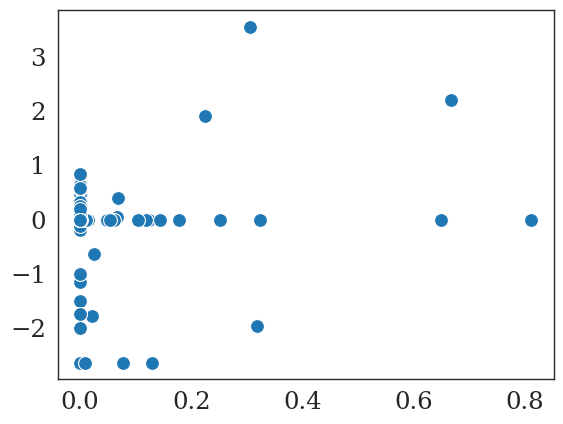

In [45]:
id_species = 0
x = df_speciesMetab_cluster.iloc[id_species, :].values
y = df_metab_pert.iloc[id_species, :].values
plt_ = sns.scatterplot(x=x, y=y, s=100)
print(scipy.stats.pearsonr(x, y))

In [50]:
corr_consp_pert = np.zeros((num_species, 2))
corr_consp_pert_sp = np.zeros((num_species, 2))
for id_species_ in range(num_species):
    x = df_speciesMetab_cluster.iloc[id_species_, :].values
    y = df_metab_pert.iloc[id_species_, :].values
    corr_consp_pert[id_species_, :] = scipy.stats.pearsonr(x, y)
    corr_consp_pert_sp[id_species_, :] = scipy.stats.spearmanr(x, y)

Text(0.5, 1.0, 'average corr. = 0.27,\n p-value = 2.62 $\\times 10^{-27}$')

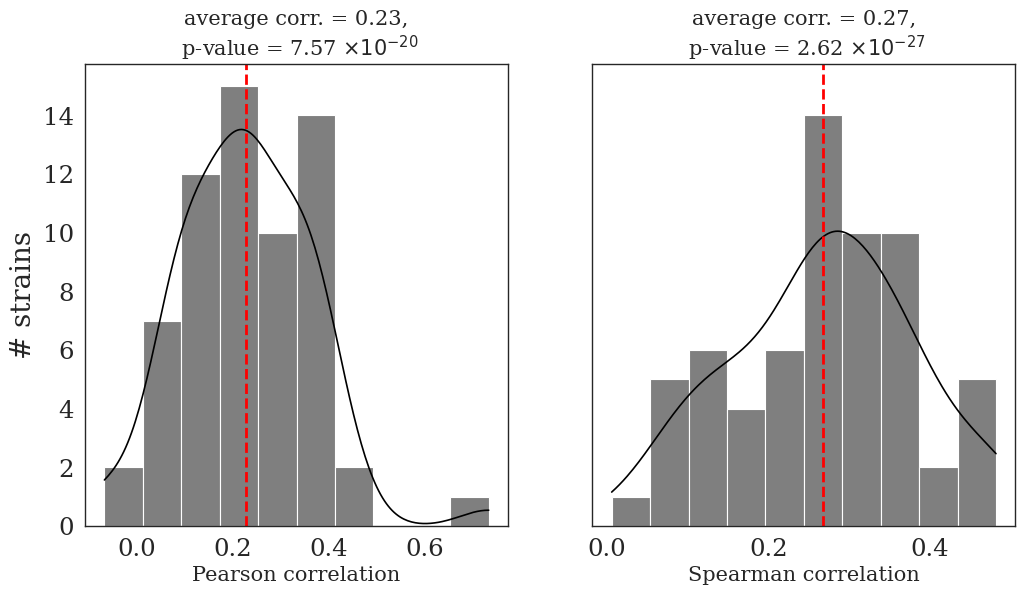

In [86]:
# 1 x 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey="row", sharex=None)

# plot 1 for Pearson correlation
plt_ = sns.histplot(corr_consp_pert[:, 0], kde=True, color='black', bins=10, ax=axes[0])
plt_.set_xlabel('Pearson correlation', fontsize=15)
# print '# strains' on ylabel
plt_.set_ylabel('# strains', fontsize=20)
# vertical line at average
plt_.axvline(x=np.mean(corr_consp_pert[:, 0]), color='red', linestyle='dashed', linewidth=2)
# print average pearson correlation with p-value in scientific notation in the title
t_statistic, p_value = scipy.stats.ttest_1samp(corr_consp_pert[:, 0], 0)
p_value_power = (np.floor(np.log10(p_value)))
p_value_a = np.round(p_value / np.power(10, p_value_power), 2)
p_value_power = int(p_value_power)
p_value_formated = f"{p_value_a} $\\times 10^{{{p_value_power}}}$"
title_ = f'average corr. = {np.mean(corr_consp_pert[:, 0]):.2f},\n p-value = {p_value_formated}'
plt_.set_title(title_, fontsize=15)

# plot 2 for Spearman correlation
plt_ = sns.histplot(corr_consp_pert_sp[:, 0], kde=True, color='black', bins=10, ax=axes[1])
plt_.set_xlabel('Spearman correlation', fontsize=15)
# vertical line at average
plt_.axvline(x=np.mean(corr_consp_pert_sp[:, 0]), color='red', linestyle='dashed', linewidth=2)
# print average spearman correlation with p-value in scientific notation in the title
t_statistic, p_value = scipy.stats.ttest_1samp(corr_consp_pert_sp[:, 0], 0)
p_value_power = (np.floor(np.log10(p_value)))
p_value_a = np.round(p_value / np.power(10, p_value_power), 2)
p_value_power = int(p_value_power)
p_value_formated = f"{p_value_a} $\\times 10^{{{p_value_power}}}$"
title_ = f'average corr. = {np.mean(corr_consp_pert_sp[:, 0]):.2f},\n p-value = {p_value_formated}'
plt_.set_title(title_, fontsize=15)

In [74]:
value = 5  # Example variable

# Create the LaTeX expression within an f-string
latex_expression = f"10^{{{p_value_power}}}"

In [75]:
latex_expression

'10^{-20}'

Fig 4

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

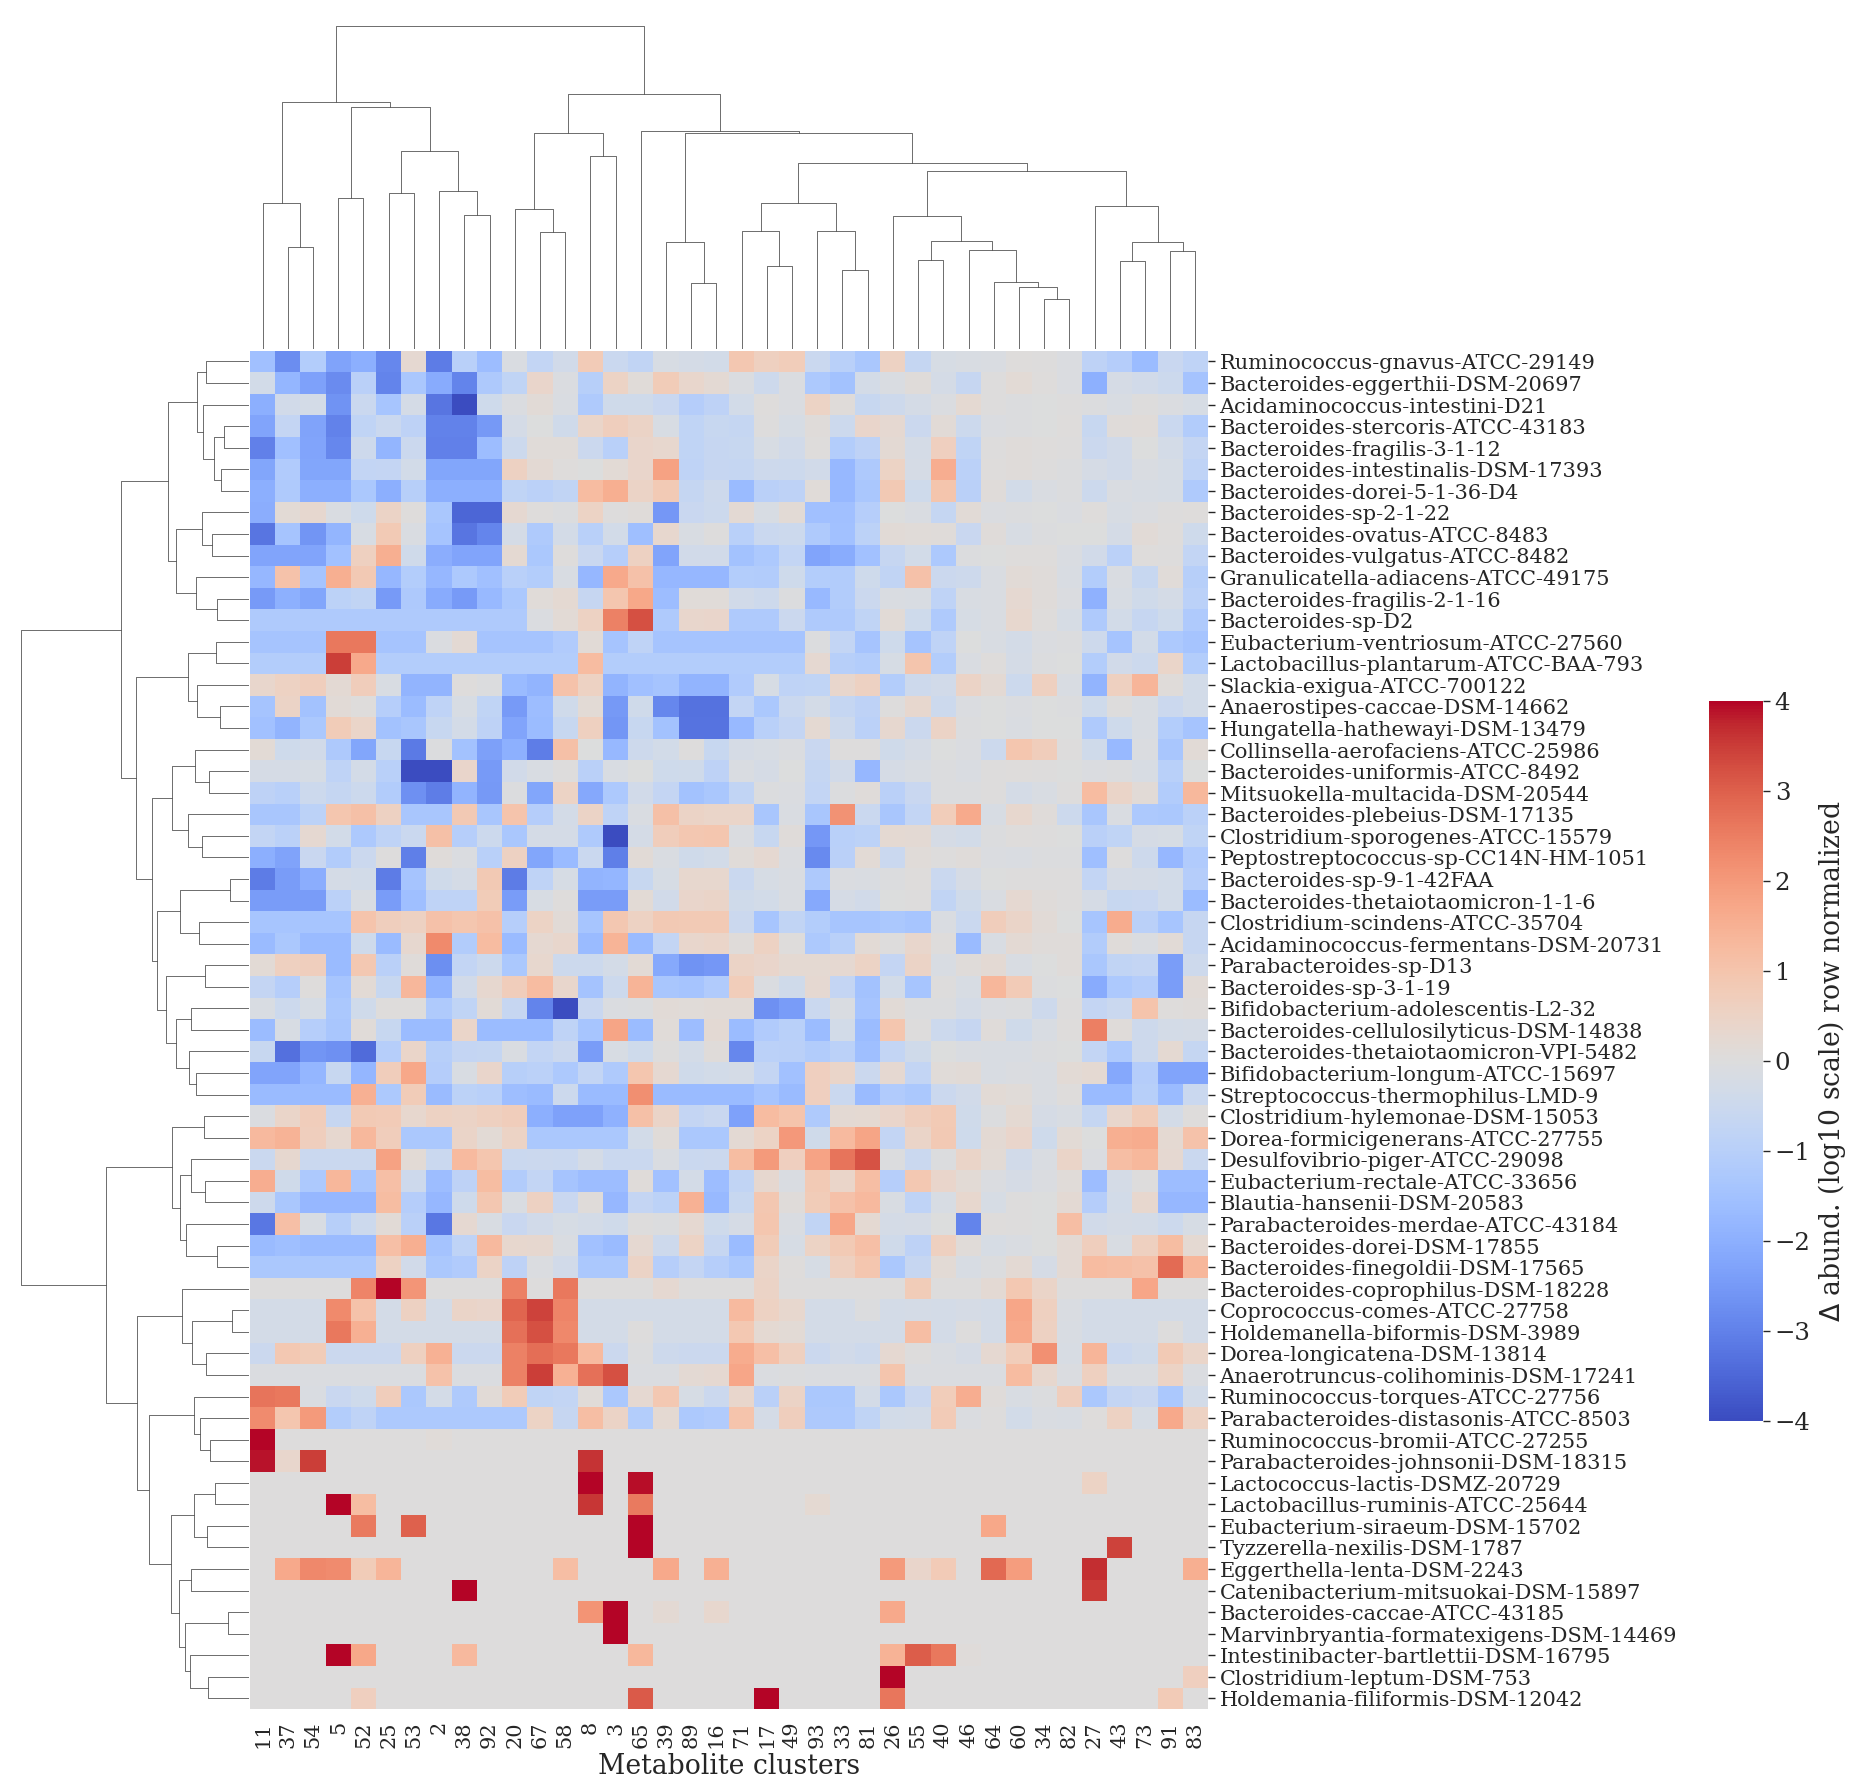

In [35]:
# FIG. 4. Response of strain abundances to increases in concentrations of individual metabolites.
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
plt.rc('font', family='serif')
pass_ = 2
pass_keep = remove_passages(pass_rm_list=[0, 1, 3, 4, 5])
abun_avg_pass_3 = np.array(df_speciesAbun_mdl.iloc[:, pass_keep])
abun_avg_pass_3 = np.mean(np.log10(abun_avg_pass_3), axis=1)
id_species_order = np.argsort(-abun_pred)
species_names_order = species_names[id_species_order]
sorted_tensor_order = (abun_pred[id_species_order])
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
Ri_avg[Ri_avg <= 1e-12] = 1e-12
id_nnz = np.where(Ri_avg >= 1e-9)[0]
Ri_avg = Ri_avg[id_nnz]
id_metabs_order = np.argsort(-Ri_avg)
df_tmp = df_metab_pert.copy()
df_tmp = df_tmp.iloc[:, id_nnz]
df_tmp = df_tmp.loc[species_names_order, :]
df_tmp = df_tmp.iloc[:, id_metabs_order]
# df_tmp[df_tmp > 0] = 1
# df_tmp[df_tmp < 0] = -1
# f, axs = plt.subplots(1, 3, figsize=(18, 18), \
#                       sharey=False, gridspec_kw=dict(width_ratios=[3,1.5,5]))
thresh_ = 4
# df_tmp[df_tmp >= thresh_] = thresh_
# df_tmp[df_tmp <= -thresh_] = -thresh_
min_value = 0
max_value = 1
df = df_tmp.copy()
df = df.transpose()
# df_normalized = (df - df.mean()) / df.std()
df_normalized = (df.copy()) / df.copy().std()
# df_normalized = df.copy()
df_normalized = df_normalized.transpose()
df_normalized = df_normalized.fillna(0)
df_normalized[df_normalized >= thresh_] = thresh_
df_normalized[df_normalized <= -thresh_] = -thresh_
plt_ = sns.clustermap(df_normalized, \
                      cmap="coolwarm", figsize=(18, 18), \
                      metric="euclidean", xticklabels=True, yticklabels=True, \
                      row_cluster=True, col_cluster=True, \
                      cbar_kws={'shrink': 0.1, 'label': r'$\Delta$ abund. (log10 scale) row normalized'}, \
                      cbar_pos=(0.96, .2, .03, .4), method='ward', z_score=None)
# plt_.ax_col_dendrogram.set_visible(False)
# plt_.ax_row_dendrogram.set_visible(False)
plt_.ax_heatmap.set_xlabel('Metabolite clusters')
# plt_.fig.subplots_adjust(right=0.7)
# plt_.ax_cbar.set_position((0.1, .2, .03, .4))
plt.setp(plt_.ax_heatmap.get_xticklabels(), rotation=90, fontsize=15)
plt.setp(plt_.ax_heatmap.get_yticklabels(), rotation=0, fontsize=15)

In [74]:
id_species_order = np.argsort(-abun_pred)
species_names_order = species_names[id_species_order]
abun_pred_sorted = abun_pred[id_species_order].copy()
id_ = np.array([49, 50, 51, 52, 53, 54, 55, 57, 61, 62], dtype=int)
print(id_)
print(abun_pred_sorted[id_])
print(len(id_))
id_strains_insensitive = id_species_order[id_] # IDs of strains that are insensitive to metabolite perturbations
print(abun_pred[id_strains_insensitive])
print(species_names[id_strains_insensitive])

[49 50 51 52 53 54 55 57 61 62]
[1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
10
[1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
['Bacteroides-caccae-ATCC-43185' 'Ruminococcus-bromii-ATCC-27255'
 'Bacteroides-coprophilus-DSM-18228' 'Parabacteroides-johnsonii-DSM-18315'
 'Lactococcus-lactis-DSMZ-20729' 'Marvinbryantia-formatexigens-DSM-14469'
 'Lactobacillus-ruminis-ATCC-25644' 'Clostridium-leptum-DSM-753'
 'Catenibacterium-mitsuokai-DSM-15897' 'Tyzzerella-nexilis-DSM-1787']


# 5. plots for the greedy algorithm for equalizing strain abundances in the community

In [77]:
count_p = 0
p_vec_new_tmp = [0.1]
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
x = Ri_avg.copy()
zero_thresh_Ri = 1e-12
x[x <= zero_thresh_Ri] = zero_thresh_Ri
id_metabs_keep = []
nsols = len(solution_list)

for n_ in range(nsols):
    y = solution_list[n_].copy()
    y[y <= zero_thresh_Ri] = zero_thresh_Ri
    id_ = np.where(np.log10(y) - np.log10(x) != 0)[0]
    if n_ == 0:
        id_metabs_keep += list(id_.copy())
    else:
        id_metabs_keep = list(set(id_metabs_keep).union(set(list(id_.copy()))))

In [78]:
print(len(id_metabs_keep))
len(np.where(Ri_noMicrocosm_dynamicAll_fit_joint[0][id_metabs_keep] >= 1e-8)[0])

56


20

In [79]:
len(id_metabs_keep)

56

In [80]:
len(np.where(Ri_noMicrocosm_dynamicAll_fit_joint[0] >= 1e-8)[0])

38

In [81]:
count_p = 0
p_vec_new_tmp = [0.1]
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
x = Ri_avg.copy()
zero_thresh_Ri = 1e-12
x[x <= zero_thresh_Ri] = zero_thresh_Ri
df_tmp = pd.DataFrame()
df_tmp_abs = pd.DataFrame()
df_tmp_full = pd.DataFrame()
for n_ in range(nsols):
    y = solution_list[n_].copy()
    y[y <= zero_thresh_Ri] = zero_thresh_Ri
    df_tmp[f'repeat_{n_ + 1}'] = np.log10(y[id_metabs_keep].copy()) - \
        np.log10(x[id_metabs_keep].copy())
    df_tmp_abs[f'repeat_{n_ + 1}'] = np.log10(y[id_metabs_keep].copy())
    df_tmp_full[f'repeat_{n_ + 1}'] = np.log10(y[:].copy())
df_tmp.index = df_metabs_clusters['cluser_metab_names'].values[id_metabs_keep]
df_tmp.index = np.array(id_metabs_keep) + 1
df_tmp_abs.index = df_metabs_clusters['cluser_metab_names'].values[id_metabs_keep]
df_tmp_abs.index = np.array(id_metabs_keep) + 1
# df_tmp_full.index = df_metabs_clusters['cluser_metab_names'].values[id_metabs_keep]
df_tmp_full.index = np.arange(df_tmp_full.shape[0]) + 1

In [82]:
len(id_metabs_keep)

56

In [83]:
id_strains_sensitive = set(list(np.arange(num_species))) - \
    set(list(id_strains_insensitive))
id_strains_sensitive = np.array(list(id_strains_sensitive))

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

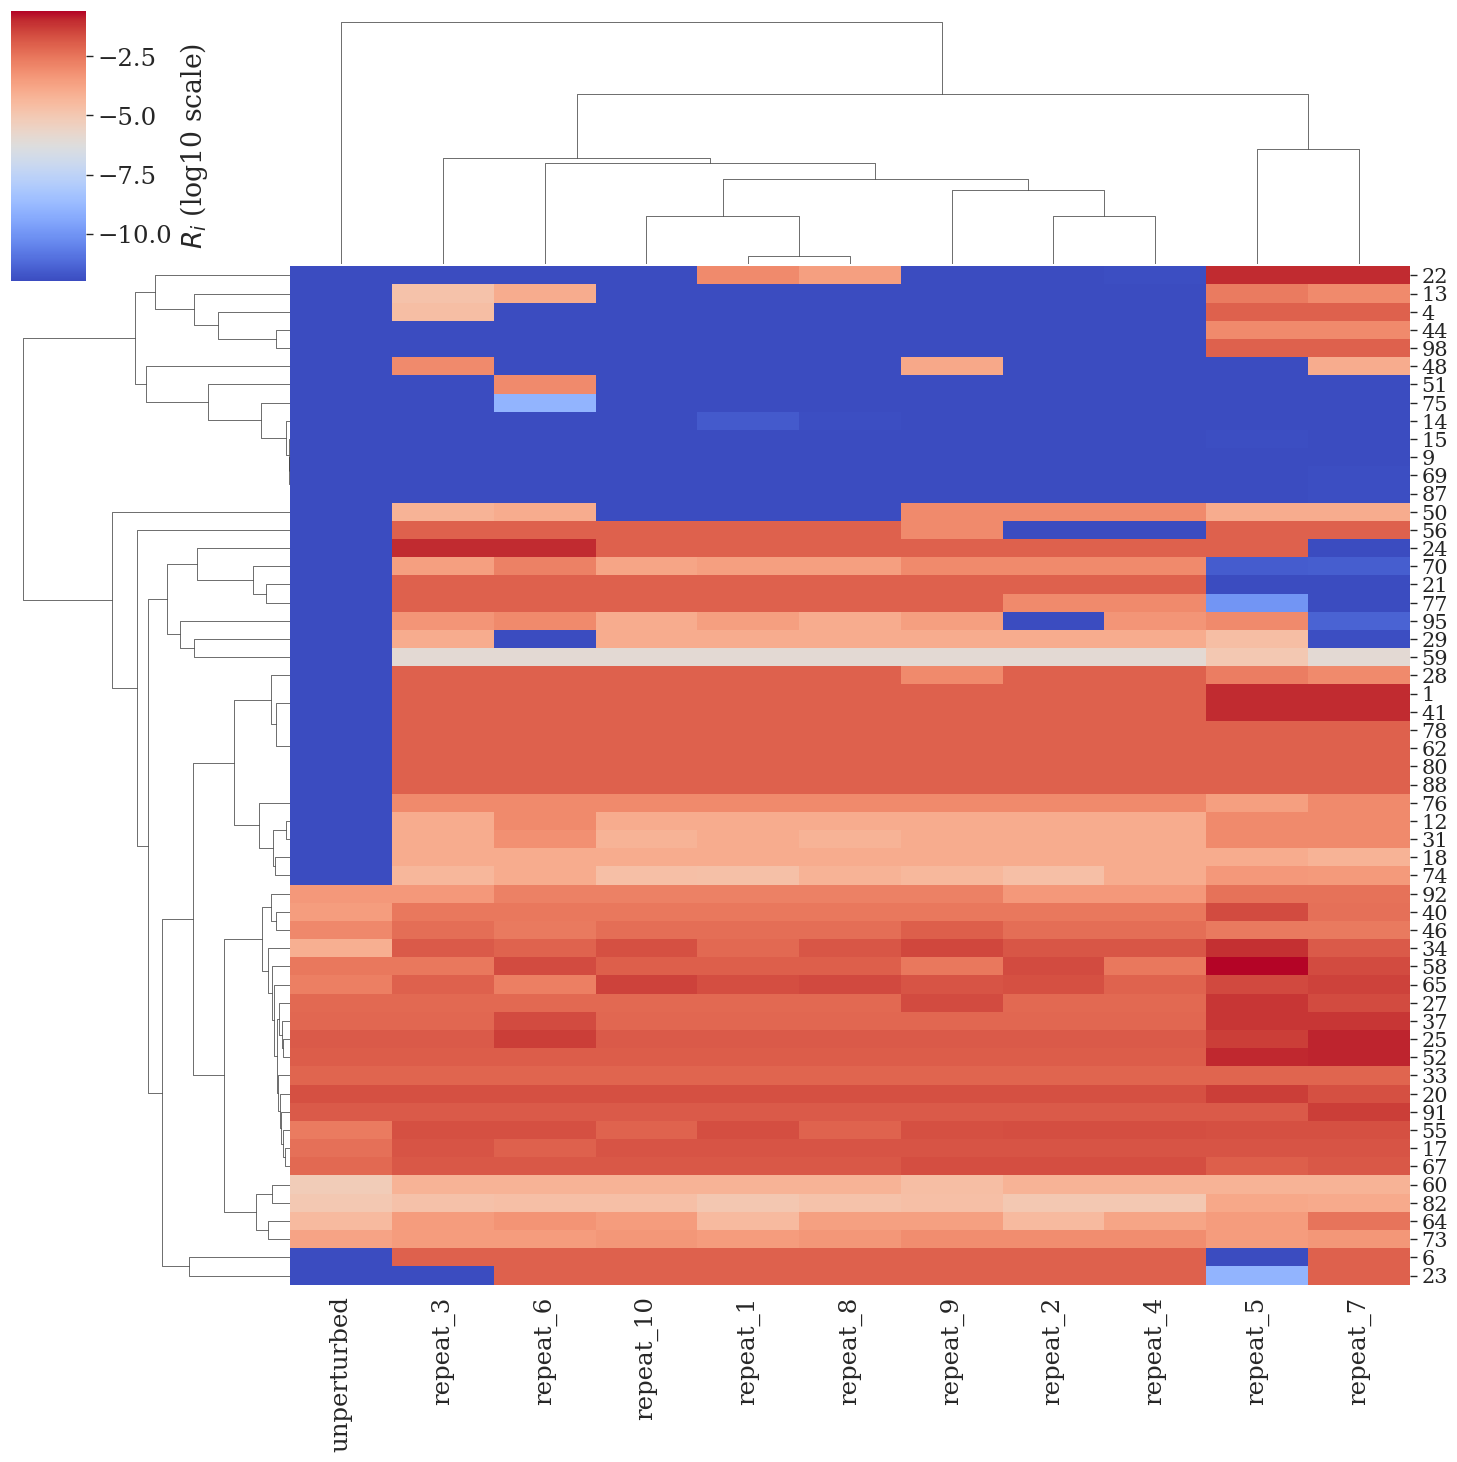

In [84]:
# fig. S8
date_ = '20230912'
date_meeting = '20230912'
date_ = "20231015"
date_meeting = "20231015"
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
plt.rc('font', family='serif')
red_ = '#e41a1c'
blue_ = '#4daf4a'
df_copy = df_tmp_abs.copy()
count_p = 0
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
x = Ri_avg.copy()
zero_thresh_Ri = 1e-12
x[x <= zero_thresh_Ri] = zero_thresh_Ri
df_copy['unperturbed'] = np.log10(x[id_metabs_keep])
plt_ = sns.clustermap(df_copy, \
                      cmap="coolwarm", figsize=(15, 15), \
                      metric=distance_metric, xticklabels=True, yticklabels=True, \
                      cbar_kws={'shrink': 0.1, 'label': r'$R_i$ (log10 scale)'})
plt.setp(plt_.ax_heatmap.get_yticklabels(), rotation=0, fontsize=15)
# plt_.legend(title=r'$R_i$ (log scale)', fontsize=12)
# colorbar_title = plt_.cax.set_title(r'$R_i$ (log scale)', pad=20)
# colorbar_title.set_ha('left')

# file_save = {path to save the figure}

# plt.savefig(file_save, \
#                     dpi=300, transparent=False, facecolor="white")



In [86]:
def normalize_columns(df_):
    for col_ in df_.columns.values:
        df_[col_] /= np.sum(df_[col_].values)
    return df_

In [87]:
# RMSE for equalized community
date_ = "20231015"
date_meeting = "20231015"
count_p = 0
p_vec_new_tmp = [0.1]
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
x = Ri_avg.copy()
zero_thresh_Ri = 1e-12
x[x <= zero_thresh_Ri] = zero_thresh_Ri

avg_changed_ = np.median(np.array(df_tmp_abs), axis=1)
x[id_metabs_keep] = 10**avg_changed_.copy()
Ri_pert = x.copy()
# x = 10.0**np.mean(np.array(df_tmp_full.copy()), axis=1)
Ri_fit = {0: x.copy()}


id_strains_sensitive = set(list(np.arange(num_species))) - \
    set(list(id_strains_insensitive))
id_strains_sensitive = np.array(list(id_strains_sensitive))
id_tmp = id_strains_insensitive.copy()

df_speciesAbun_inoc_tmp = df_speciesAbun_inoc.copy()
df_speciesAbun_inoc_tmp.iloc[id_tmp, :] = 1e-8
df_speciesAbun_inoc_tmp = normalize_columns(df_speciesAbun_inoc_tmp.copy())
df_speciesAbun_inoc_tmp.iloc[id_tmp, :] = 1e-8

df_speciesAbun_tmp = df_speciesAbun_mdl.copy()
df_speciesAbun_tmp.iloc[id_tmp, :] = 1e-8
df_speciesAbun_tmp = normalize_columns(df_speciesAbun_tmp.copy())
df_speciesAbun_tmp.iloc[id_tmp, :] = 1e-8

df_speciesAbun_prev_tmp = df_speciesAbun_prev_mdl.copy()
df_speciesAbun_prev_tmp.iloc[id_tmp, :] = 1e-8
df_speciesAbun_prev_tmp = normalize_columns(df_speciesAbun_prev_tmp.copy())
df_speciesAbun_prev_tmp.iloc[id_tmp, :] = 1e-8

df_speciesAbun_ratio_tmp = df_speciesAbun_ratio_mdl.copy()
df_speciesAbun_ratio_tmp.iloc[id_tmp, :] = 1

num_metabs_clust = df_speciesMetab_cluster.shape[1] - 1
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
df_speciesMetab_prod_tmp = df_speciesMetab_prod_cluster.copy()
num_iter_1 = 100
sens_obj_uni_avg, RMSE_obj_all_prod = \
    blindly_pred_abun_growth(p_vec_new_tmp, df_speciesMetab_tmp, \
                             df_speciesAbun_inoc_tmp, df_speciesAbun_tmp, \
                             df_speciesAbun_prev_tmp, \
                             df_speciesAbun_ratio_tmp, \
                             Ri_fit, "dummy", "dummy", \
                             "dummy", num_passages=6, num_iter=100, \
                             thresh_zero=1e-8, Ri_ss=False, plot_=False, \
                             save_data_obj=False, \
                             return_sensitivity_ana=True, \
                             get_prod=True, B_alone=N_alone_iter[num_iter_1 - 2], \
                             df_speciesMetab_prod=df_speciesMetab_prod_tmp, \
                             prod_use_prev=False, num_passages_run=3, \
                             use_dilution=True, \
                             dilution_factor=15000, \
                             id_species_update=id_strains_sensitive, \
                             use_avg_for_prod=False)
pass_ = 2
pred_dist_all = sens_obj_uni_avg[pass_]['df_speciesAbun_next_pred'].copy()
pred_dist_all[pred_dist_all <= 1e-8] = 1e-8
species_names_all = sens_obj_uni_avg[pass_]['species_names']
id_species_rep = np.arange(num_species) * 3
pred_dist = pred_dist_all[id_species_rep]
# pred_dist = np.zeros((num_species))
# for species_ in range(num_species):
#     id_ = np.array([0, 1, 2]) + species_ * 3
#     pred_dist[species_] = np.exp(np.mean(np.log(pred_dist_all[id_])))

# Fig. 4

Text(0.1, 1.0, 'b')

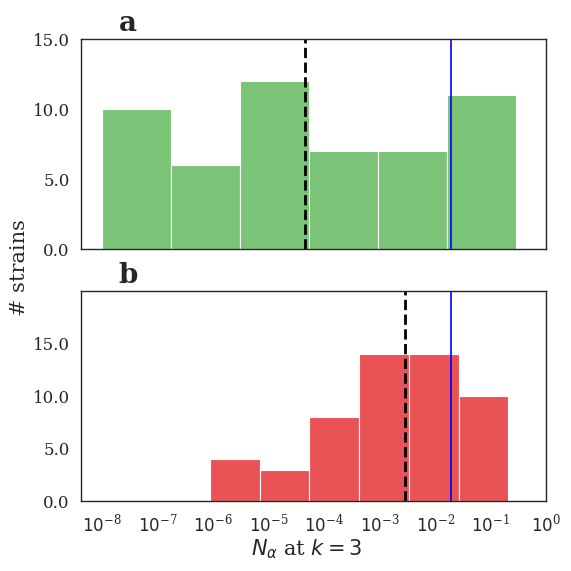

In [89]:
# Fig 4
red_ = '#e41a1c'
blue_ = '#4daf4a'
num_iter = 100
id_select = 0 + np.arange(num_species) * 3
pass_ = 2
x_pred = sens_obj_uni_avg[pass_]['df_speciesAbun_next_pred'][id_select].copy()
x_obs = sens_obj_all_prod[pass_]['df_speciesAbun_next_pred'][id_select].copy()
x_pred[x_pred <= 1e-8] = 1e-8
x_obs[x_obs <= 1e-8] = 1e-8

x_pred = x_pred[id_strains_sensitive]
x_pred /= np.sum(x_pred)
x_obs = x_obs[id_strains_sensitive]
x_obs /= np.sum(x_obs)
# fig, axes = plt.subplots(2, int(num_passages / 2), \
#                              figsize=(40, 35), sharey="row", sharex="col")
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
plt.rc('font', family='serif')
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharey="row", sharex="col")
fig.supylabel('# strains', fontsize=15, x=0.006)
fig.supxlabel(fr"$N_{{\alpha}}$ at $k=3$", fontsize=15)
nbins_ = 6
plt_ = sns.histplot(x=np.log10(x_obs), ax=axes[0], bins=nbins_, color=blue_)
# axes[0].set_yscale('log', base=10)
# axes[0].invert_xaxis() 
xticks_ = np.arange(-8, 1, step=1)
xlabs_ = []
for x_ in xticks_:
    xlabs_.append(fr"${10}^{{\mathregular{{{x_}}}}}$")
# axes[0].set_xticks(xticks_, labels=xlabs_, fontsize=15)
axes[0].set_yticks(axes[0].get_yticks(), labels=axes[0].get_yticks(), fontsize=12)
# axes[0].axvline(np.log10(1 / num_species), c="blue")
axes[0].axvline(np.log10(1 / len(x_obs)), c="blue")
axes[0].set_xlabel(None)
axes[0].set_ylabel(None)
axes[0].axvline(np.median(np.log10(x_obs)), color='k', ls='--', lw=2)
axes[0].set_title('a', fontsize=20, x=0.1, weight='bold')

nbins_ = 6
plt_ = sns.histplot(x=np.log10(x_pred), ax=axes[1], bins=nbins_, color=red_)
# axes[1].invert_xaxis()
axes[1].set(ylim=(0, 20))
axes[1].set_xticks(xticks_, labels=xlabs_, fontsize=12)
axes[1].set_yticks(axes[0].get_yticks(), labels=axes[0].get_yticks(), fontsize=12)
axes[1].axvline(np.log10(1 / len(x_pred)), c="blue")
axes[1].set_xlabel(None)
axes[1].set_ylabel(None)

id_strains_sensitive = list(set(list(np.arange(num_species))) - \
                            set(list(id_strains_insensitive)))
axes[1].axvline(np.median(np.log10(x_pred[:])), color='k', ls='--', lw=2)
axes[1].set_title('b', fontsize=20, x=0.1, weight='bold')

# file_save = {path to save figure}

# plt.savefig(file_save, \
#                     dpi=300, transparent=False, facecolor="white")